# Three jump specification

- first two: change of $\vartheta$ 

    $\vartheta = 0.453$ and $\lambda = 0.1206$,
    
    - to $\frac12 \vartheta$, $\vartheta  = 0.0260$, $\lambda = 0.0798$
    - to 0, no emission

- Third jump, damage jump

In [188]:
# packages
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from multiprocessing import Pool
from scipy.interpolate import RegularGridInterpolator, CubicSpline
import matplotlib.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from derivative import derivatives_2d
import time
from numba import njit
from supportfunctions import PDESolver_2d, finiteDiff
from solver_1d import false_transient_one_iteration_python
import pickle
import numpy as np
import pandas as pd

# from DICE_damage_tech import solve_postdmg, solve_predmg

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'


class GridInterp_2d():
    def __init__(self, grids, values, method='Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)

        self.values = values

        assert (self.nx,
                self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':

            func = RegularGridInterpolator(self.grids, self.values)
            return func([x, y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)

            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

In [189]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_bar = 2.3
y_jump = 2.
y_overline = 2.3
y = 2.5
damage_min = γ1*(y - y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max = γ1*(y - y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 10)
γ3_list = 2*(- np.log(damages) - γ1*(y - y_jump+2) -
             γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α
# ϑ, λ settings
## year 2020
ϑ_0 = 0.0453
λ_0 = 0.1206
## 25 years later
I_g_0 = 1/25
ϑ_1 = 0.0453/2
λ_1 = 0.1206/2
## 50 years later
I_g_1 = 1/25
ϑ_2 = 0
λ_2 = 0

In [340]:
y_step = 0.05
y_grid = np.arange(0., 5. + y_step, y_step)

k_step = 0.1
k_grid = np.arange(4., 10. + k_step, k_step)

hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [191]:
np.log(80/α)

6.544849785292769

In [192]:
def solve_parallel(args_list, func):
    with Pool() as p:
        res_list = p.starmap(func, args_list)
    return res_list

In [193]:
def solve_postdmg(y_grid,
                  k_grid,
                  args,
                  post_tech=True,
                  v_tech=None,
                  v0=None,
                  ϵ=2,
                  tol=1e-6,
                  max_iter=2_000,
                  print_all=False):

    (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar,
     I_g), (γ1, γ2, γ3, y_bar), (θ_list, σy), (ξa, ξp, ξg) = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]

    (k_mat, y_mat) = np.meshgrid(k_grid, y_grid, indexing='ij')
    stateSpace = np.hstack(
        [k_mat.reshape(-1, 1, order='F'),
         y_mat.reshape(-1, 1, order='F')])
    πa_o = np.ones((len(θ_list), n_k, n_y)) / len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_k, n_y))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o

    dΛ = γ1 + γ2 * y_mat + γ3 * (y_mat - y_bar) * (y_mat > y_bar)
    ddΛ = γ2 + γ3 * (y_mat > y_bar)

    # initial guess
    if v0 is None:
        v0 = (1 / δ) * k_mat - y_mat**2
    # initial i
    v0_dk = derivatives_2d(v0, 0, 1, dk)
    a_i = κ * v0_dk
    b_i = -(1 + α * κ) * v0_dk
    c_i = α * v0_dk - 1
    i = (-b_i - np.sqrt(b_i**2 - 4 * a_i * c_i)) / (2 * a_i)

    ems = np.zeros(k_mat.shape)
    mc = 1 / (α - i - α * ϑ_bar * (1 - ems / (np.exp(k_mat) * α * λ_bar))**θ)

    episode = 0
    lhs_error = 0.5
    vd = -1 / δ

    while lhs_error > tol and episode < max_iter:
        vold = v0.copy()
        v0_dk = derivatives_2d(v0, 0, 1, dk)
        v0_dkk = derivatives_2d(v0, 0, 2, dk)
        v0_dy = derivatives_2d(v0, 1, 1, dy)
        v0_dyy = derivatives_2d(v0, 1, 2, dy)
        # updating controls
        i_new = (1 - mc / v0_dk) * (1 / κ)
        #     update emission
        if θ == 2 or ϑ_bar == 0:
            a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc * \
                θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
            b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
                + vd*dΛ*np.sum(θ_mat*πa, axis=0)
            ems_new = -b / a
        elif θ == 3:
            a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) / \
                (α**2*λ_bar**2*np.exp(2*k_mat))
            b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2 / \
                (α*λ_bar*np.exp(k_mat)) + (v0_dyy + vd*ddΛ)*σy**2
            c = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + \
                (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
            Δ = b**2 - 4 * a * c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ)) / (2 * a)
            root2 = (-b + np.sqrt(Δ)) / (2 * a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2
        ems_new[ems_new < 1e-8] = 1e-8
        i_new = i_new * 0.02 + i * 0.98
        ems_new = ems_new * 0.02 + ems * 0.98
        ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat))) * \
            ((1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0)
        #     ratio[ratio > 1] = 1
        consumption = α - i_new - α * ϑ_bar * ratio**θ
        consumption[consumption <= 1e-9] = 1e-9
        mc_new = 1 / consumption
        #     mc_new[mc_new <= 1e-15] = 1e-15
        #     mc_new = mc_new*0.05 + mc*0.95
        temp = v0_dy + vd * dΛ
        weight = np.array([-1 / ξa * temp * ems_new * θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o * np.exp(weight)
        πa[πa <= 0] = 1e-16
        πa = πa / np.sum(πa, axis=0)
        # HJB coefficient
        entropy = np.sum(πa * (np.log(πa) - np.log(πa_o)), axis=0)

        B_y = np.sum(θ_mat * πa, axis=0) * ems_new
        B_k = μk + i_new - 0.5 * κ * i_new**2 - 0.5 * σk**2
        C_yy = 0.5 * ems_new**2 * σy**2
        C_kk = 0.5 * σk**2 * np.ones(k_mat.shape)
        if post_tech:
            A = -δ * np.ones(k_mat.shape)
            D = np.log(consumption) + k_mat + vd * (
                dΛ * np.sum(θ_mat * πa, axis=0) * ems_new +
                0.5 * ddΛ * σy**2 * ems_new**2) + ξa * entropy
        else:
            g_tech = np.exp(1 / ξg * (v0 - v_tech))
            A = -δ * np.ones(k_mat.shape) - I_g * g_tech
            D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new \
                + 0.5*ddΛ*σy**2*ems_new**2)\
                + ξa*entropy\
                + I_g*g_tech*v_tech\
                + ξg*I_g*(1 - g_tech + g_tech*np.log(g_tech))
        # PDE solver
        out = PDESolver_2d(stateSpace,
                           A,
                           B_k,
                           B_y,
                           C_kk,
                           C_yy,
                           D,
                           v0,
                           ϵ,
                           solverType='False Transient')
        out_comp = out[2].reshape(v0.shape, order="F")
        rhs = A * v0 + B_y * v0_dy + B_k * v0_dk + C_yy * v0_dyy + C_kk * v0_dkk + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - vold) / ϵ))
        if print_all:
            print(
                "Ep: {:d}; PDE Err: {:.12f}; ft Err: {:.12f}; Iter: {:d}; CG Err:{:.12f}"
                .format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems = ems_new
        mc = mc_new
        i = i_new
    print(
        "Ep: {:d}; PDE Err: {:.12f}; ft Err: {:.12f}; Iter: {:d}; CG Err:{:.12f}"
        .format(episode, rhs_error, lhs_error, out[0], out[1]))

    if post_tech:
        res = dict(
            v0=v0,
            ems=ems,
            inv=i,
            πa=πa,
        )
    else:
        res = dict(
            v0=v0,
            ems=ems,
            inv=i,
            πa=πa,
            g_tech=g_tech
        )
    return res

## Step 1:

Post second jump of technology, post damage:

No emission,  $\alpha = 0.115$, $\phi_m^{(2)}$:

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi(k, y) + \log(\alpha - i ) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)
\end{aligned}
$$


In [194]:
θ = 3
ϑ_bar = ϑ_2
λ_bar = λ_1
I_g = I_g_1
arg_list_tech2 = []
for γ3_i in γ3_list:
    econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
    dmg_param = (γ1, γ2, γ3_i, y_bar)
    climate_param = (θ_list, σy)
    uncertain_param = (100_000, 100_000, 100_000)
    args = (econ_param, dmg_param, climate_param, uncertain_param)
    args_func = (y_grid, k_grid, args, True, None, None, 2, 1e-6, 4_000)
    arg_list_tech2.append(args_func)

res_tech2 = solve_parallel(arg_list_tech2, solve_postdmg)

Ep: 729; PDE Err: 0.000000999927; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033
Ep: 729; PDE Err: 0.000000999926; ft Err: 0.000000983359; Iter: 3; CG Err:0.000000000033


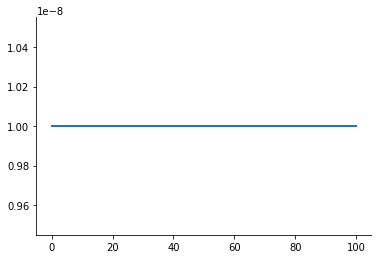

In [195]:
plt.plot(res_tech2[0]['ems'][0])
plt.show()

## Step 2:

post damage,

post 1st tech jump, and pre 2nd tech jump:


For each $\gamma_3$, $\alpha = 0.115$


$\vartheta = 0.0260$,  and $\lambda = 0.0798$, $\phi_m^{(1)}$

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi^{(1)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell) \\
& + I_g (\phi^{(2)} - \phi^{(1)}(k, y))
\end{aligned}
$$

In [196]:
θ = 3
ϑ_bar = ϑ_1
λ_bar = λ_1
I_g = I_g_1
i = 0
args = ((δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g),
        (γ1, γ2, γ3_list[i], y_bar), (θ_list, σy), (100_000, 100_000, 100_000))
res = solve_postdmg(y_grid, k_grid, args, False, res_tech2[i]['v0'],
                   None, 0.5, 1e-6, 2_000, True)

Ep: 0; PDE Err: 8.575874106328; ft Err: 8.366632870092; Iter: 8; CG Err:0.000000000012
Ep: 1; PDE Err: 8.364402220235; ft Err: 8.160470377982; Iter: 8; CG Err:0.000000000022
Ep: 2; PDE Err: 8.158651175764; ft Err: 7.959825632984; Iter: 8; CG Err:0.000000000038
Ep: 3; PDE Err: 7.958228148814; ft Err: 7.764396688700; Iter: 8; CG Err:0.000000000066
Ep: 4; PDE Err: 7.763021931595; ft Err: 7.573977805368; Iter: 9; CG Err:0.000000000015
Ep: 5; PDE Err: 7.572687112243; ft Err: 7.388373023671; Iter: 9; CG Err:0.000000000040
Ep: 6; PDE Err: 7.387162313098; ft Err: 7.207384061363; Iter: 9; CG Err:0.000000000089
Ep: 7; PDE Err: 7.206298279035; ft Err: 7.030906828385; Iter: 10; CG Err:0.000000000039
Ep: 8; PDE Err: 7.029911609992; ft Err: 6.858864637897; Iter: 10; CG Err:0.000000000074
Ep: 9; PDE Err: 6.857886947575; ft Err: 6.691069014916; Iter: 11; CG Err:0.000000000025
Ep: 10; PDE Err: 6.690112186600; ft Err: 6.527410424041; Iter: 11; CG Err:0.000000000051
Ep: 11; PDE Err: 6.526478183196; ft Er

Ep: 93; PDE Err: 0.858555198008; ft Err: 0.837028945243; Iter: 32; CG Err:0.000000000061
Ep: 94; PDE Err: 0.837581253674; ft Err: 0.816557508536; Iter: 32; CG Err:0.000000000066
Ep: 95; PDE Err: 0.817120337585; ft Err: 0.796586738430; Iter: 32; CG Err:0.000000000072
Ep: 96; PDE Err: 0.797159919013; ft Err: 0.777104415573; Iter: 32; CG Err:0.000000000079
Ep: 97; PDE Err: 0.777687780631; ft Err: 0.758098620094; Iter: 32; CG Err:0.000000000086
Ep: 98; PDE Err: 0.758692004863; ft Err: 0.739557722751; Iter: 32; CG Err:0.000000000094
Ep: 99; PDE Err: 0.740160964401; ft Err: 0.721470488710; Iter: 33; CG Err:0.000000000062
Ep: 100; PDE Err: 0.722083341632; ft Err: 0.703825642488; Iter: 33; CG Err:0.000000000067
Ep: 101; PDE Err: 0.704448013076; ft Err: 0.686612466630; Iter: 33; CG Err:0.000000000072
Ep: 102; PDE Err: 0.687244194907; ft Err: 0.669820430276; Iter: 33; CG Err:0.000000000078
Ep: 103; PDE Err: 0.670461357766; ft Err: 0.653439255701; Iter: 33; CG Err:0.000000000084
Ep: 104; PDE Err:

Ep: 189; PDE Err: 0.081190867800; ft Err: 0.078249866425; Iter: 40; CG Err:0.000000000081
Ep: 190; PDE Err: 0.079248814600; ft Err: 0.076354188664; Iter: 40; CG Err:0.000000000082
Ep: 191; PDE Err: 0.077354199988; ft Err: 0.074504816943; Iter: 40; CG Err:0.000000000082
Ep: 192; PDE Err: 0.075505859785; ft Err: 0.072700614950; Iter: 40; CG Err:0.000000000082
Ep: 193; PDE Err: 0.073702658168; ft Err: 0.070940473658; Iter: 40; CG Err:0.000000000082
Ep: 194; PDE Err: 0.071943487154; ft Err: 0.069223311956; Iter: 40; CG Err:0.000000000082
Ep: 195; PDE Err: 0.070227266328; ft Err: 0.067548074812; Iter: 40; CG Err:0.000000000082
Ep: 196; PDE Err: 0.068552941502; ft Err: 0.065913733265; Iter: 40; CG Err:0.000000000082
Ep: 197; PDE Err: 0.066919484421; ft Err: 0.064319283924; Iter: 40; CG Err:0.000000000082
Ep: 198; PDE Err: 0.065325892420; ft Err: 0.062763747589; Iter: 40; CG Err:0.000000000082
Ep: 199; PDE Err: 0.063771187201; ft Err: 0.061246169636; Iter: 40; CG Err:0.000000000082
Ep: 200; P

Ep: 282; PDE Err: 0.009461187618; ft Err: 0.008266751968; Iter: 37; CG Err:0.000000000076
Ep: 283; PDE Err: 0.009262878785; ft Err: 0.008074259782; Iter: 37; CG Err:0.000000000074
Ep: 284; PDE Err: 0.009069327477; ft Err: 0.007886375794; Iter: 37; CG Err:0.000000000073
Ep: 285; PDE Err: 0.008880418431; ft Err: 0.007702988328; Iter: 37; CG Err:0.000000000071
Ep: 286; PDE Err: 0.008696038489; ft Err: 0.007524027773; Iter: 36; CG Err:0.000000000099
Ep: 287; PDE Err: 0.008516011005; ft Err: 0.007349343581; Iter: 36; CG Err:0.000000000097
Ep: 288; PDE Err: 0.008340338450; ft Err: 0.007178910992; Iter: 36; CG Err:0.000000000095
Ep: 289; PDE Err: 0.008168884070; ft Err: 0.007012553251; Iter: 36; CG Err:0.000000000093
Ep: 290; PDE Err: 0.008001540281; ft Err: 0.006850190823; Iter: 36; CG Err:0.000000000092
Ep: 291; PDE Err: 0.007838206825; ft Err: 0.006691711102; Iter: 36; CG Err:0.000000000090
Ep: 292; PDE Err: 0.007678786408; ft Err: 0.006537017367; Iter: 36; CG Err:0.000000000088
Ep: 293; P

Ep: 380; PDE Err: 0.002413121625; ft Err: 0.000940855291; Iter: 30; CG Err:0.000000000099
Ep: 381; PDE Err: 0.002397767938; ft Err: 0.000924927820; Iter: 30; CG Err:0.000000000097
Ep: 382; PDE Err: 0.002382789310; ft Err: 0.000909185461; Iter: 30; CG Err:0.000000000095
Ep: 383; PDE Err: 0.002368176487; ft Err: 0.000893613169; Iter: 30; CG Err:0.000000000093
Ep: 384; PDE Err: 0.002353920325; ft Err: 0.000878198407; Iter: 30; CG Err:0.000000000091
Ep: 385; PDE Err: 0.002340012143; ft Err: 0.000862930410; Iter: 30; CG Err:0.000000000089
Ep: 386; PDE Err: 0.002326443322; ft Err: 0.000847800583; Iter: 30; CG Err:0.000000000087
Ep: 387; PDE Err: 0.002313205571; ft Err: 0.000832801859; Iter: 30; CG Err:0.000000000085
Ep: 388; PDE Err: 0.002300290699; ft Err: 0.000818116887; Iter: 30; CG Err:0.000000000083
Ep: 389; PDE Err: 0.002287690852; ft Err: 0.000805142778; Iter: 30; CG Err:0.000000000081
Ep: 390; PDE Err: 0.002275398297; ft Err: 0.000792354222; Iter: 30; CG Err:0.000000000079
Ep: 391; P

Ep: 478; PDE Err: 0.001847639590; ft Err: 0.000304272252; Iter: 24; CG Err:0.000000000079
Ep: 479; PDE Err: 0.001846305426; ft Err: 0.000302034389; Iter: 24; CG Err:0.000000000077
Ep: 480; PDE Err: 0.001845003694; ft Err: 0.000299704003; Iter: 24; CG Err:0.000000000076
Ep: 481; PDE Err: 0.001843733814; ft Err: 0.000297194936; Iter: 23; CG Err:0.000000000098
Ep: 482; PDE Err: 0.001842487444; ft Err: 0.000294680930; Iter: 23; CG Err:0.000000000097
Ep: 483; PDE Err: 0.001841272412; ft Err: 0.000292075232; Iter: 23; CG Err:0.000000000095
Ep: 484; PDE Err: 0.001840088006; ft Err: 0.000289945177; Iter: 23; CG Err:0.000000000093
Ep: 485; PDE Err: 0.001838933261; ft Err: 0.000288517723; Iter: 23; CG Err:0.000000000091
Ep: 486; PDE Err: 0.001837807333; ft Err: 0.000287010464; Iter: 23; CG Err:0.000000000090
Ep: 487; PDE Err: 0.001836709359; ft Err: 0.000285421260; Iter: 23; CG Err:0.000000000088
Ep: 488; PDE Err: 0.001835638695; ft Err: 0.000283748616; Iter: 23; CG Err:0.000000000087
Ep: 489; P

Ep: 576; PDE Err: 0.001797791198; ft Err: 0.000208648416; Iter: 19; CG Err:0.000000000076
Ep: 577; PDE Err: 0.001797672049; ft Err: 0.000208725602; Iter: 19; CG Err:0.000000000075
Ep: 578; PDE Err: 0.001797555816; ft Err: 0.000208755388; Iter: 19; CG Err:0.000000000074
Ep: 579; PDE Err: 0.001797442441; ft Err: 0.000208736649; Iter: 19; CG Err:0.000000000073
Ep: 580; PDE Err: 0.001797331726; ft Err: 0.000208469847; Iter: 18; CG Err:0.000000000100
Ep: 581; PDE Err: 0.001797221772; ft Err: 0.000208310998; Iter: 18; CG Err:0.000000000099
Ep: 582; PDE Err: 0.001797114894; ft Err: 0.000208105663; Iter: 18; CG Err:0.000000000098
Ep: 583; PDE Err: 0.001797011054; ft Err: 0.000207850527; Iter: 18; CG Err:0.000000000097
Ep: 584; PDE Err: 0.001796909994; ft Err: 0.000207543036; Iter: 18; CG Err:0.000000000096
Ep: 585; PDE Err: 0.001796811648; ft Err: 0.000207181064; Iter: 18; CG Err:0.000000000095
Ep: 586; PDE Err: 0.001796715969; ft Err: 0.000206762784; Iter: 18; CG Err:0.000000000094
Ep: 587; P

Ep: 674; PDE Err: 0.001793350307; ft Err: 0.000139192925; Iter: 16; CG Err:0.000000000100
Ep: 675; PDE Err: 0.001793339878; ft Err: 0.000138794836; Iter: 16; CG Err:0.000000000095
Ep: 676; PDE Err: 0.001793329657; ft Err: 0.000138431976; Iter: 16; CG Err:0.000000000093
Ep: 677; PDE Err: 0.001793319649; ft Err: 0.000138070342; Iter: 16; CG Err:0.000000000091
Ep: 678; PDE Err: 0.001793309881; ft Err: 0.000137710482; Iter: 16; CG Err:0.000000000088
Ep: 679; PDE Err: 0.001793300294; ft Err: 0.000137354288; Iter: 16; CG Err:0.000000000086
Ep: 680; PDE Err: 0.001793290944; ft Err: 0.000137004550; Iter: 16; CG Err:0.000000000084
Ep: 681; PDE Err: 0.001793281770; ft Err: 0.000136663861; Iter: 16; CG Err:0.000000000082
Ep: 682; PDE Err: 0.001793272931; ft Err: 0.000136912441; Iter: 15; CG Err:0.000000000100
Ep: 683; PDE Err: 0.001793264427; ft Err: 0.000136591399; Iter: 15; CG Err:0.000000000100
Ep: 684; PDE Err: 0.001793256068; ft Err: 0.000136282292; Iter: 15; CG Err:0.000000000098
Ep: 685; P

Ep: 772; PDE Err: 0.001792952720; ft Err: 0.000145462275; Iter: 17; CG Err:0.000000000068
Ep: 773; PDE Err: 0.001792951760; ft Err: 0.000145677839; Iter: 17; CG Err:0.000000000069
Ep: 774; PDE Err: 0.001792950892; ft Err: 0.000145850084; Iter: 17; CG Err:0.000000000070
Ep: 775; PDE Err: 0.001792949937; ft Err: 0.000146410104; Iter: 16; CG Err:0.000000000100
Ep: 776; PDE Err: 0.001792949108; ft Err: 0.000146534674; Iter: 16; CG Err:0.000000000097
Ep: 777; PDE Err: 0.001792948281; ft Err: 0.000146614518; Iter: 16; CG Err:0.000000000097
Ep: 778; PDE Err: 0.001792947468; ft Err: 0.000146628297; Iter: 16; CG Err:0.000000000097
Ep: 779; PDE Err: 0.001792946690; ft Err: 0.000146578897; Iter: 16; CG Err:0.000000000098
Ep: 780; PDE Err: 0.001792945834; ft Err: 0.000146475774; Iter: 16; CG Err:0.000000000099
Ep: 781; PDE Err: 0.001792945123; ft Err: 0.000146324385; Iter: 16; CG Err:0.000000000100
Ep: 782; PDE Err: 0.001792944390; ft Err: 0.000145763968; Iter: 17; CG Err:0.000000000068
Ep: 783; P

Ep: 870; PDE Err: 0.001792918335; ft Err: 0.000100771398; Iter: 16; CG Err:0.000000000071
Ep: 871; PDE Err: 0.001792918215; ft Err: 0.000100172579; Iter: 16; CG Err:0.000000000071
Ep: 872; PDE Err: 0.001792918199; ft Err: 0.000099502103; Iter: 16; CG Err:0.000000000072
Ep: 873; PDE Err: 0.001792918130; ft Err: 0.000098759567; Iter: 16; CG Err:0.000000000073
Ep: 874; PDE Err: 0.001792918078; ft Err: 0.000097944700; Iter: 16; CG Err:0.000000000073
Ep: 875; PDE Err: 0.001792918022; ft Err: 0.000097057465; Iter: 16; CG Err:0.000000000074
Ep: 876; PDE Err: 0.001792917930; ft Err: 0.000096712455; Iter: 16; CG Err:0.000000000074
Ep: 877; PDE Err: 0.001792917867; ft Err: 0.000096399305; Iter: 16; CG Err:0.000000000075
Ep: 878; PDE Err: 0.001792917793; ft Err: 0.000096017847; Iter: 16; CG Err:0.000000000075
Ep: 879; PDE Err: 0.001792917724; ft Err: 0.000095567247; Iter: 16; CG Err:0.000000000076
Ep: 880; PDE Err: 0.001792917685; ft Err: 0.000095046762; Iter: 16; CG Err:0.000000000076
Ep: 881; P

Ep: 968; PDE Err: 0.001792915682; ft Err: 0.000050485534; Iter: 16; CG Err:0.000000000071
Ep: 969; PDE Err: 0.001792915661; ft Err: 0.000050092079; Iter: 15; CG Err:0.000000000099
Ep: 970; PDE Err: 0.001792915650; ft Err: 0.000049536934; Iter: 16; CG Err:0.000000000074
Ep: 971; PDE Err: 0.001792915602; ft Err: 0.000049037617; Iter: 16; CG Err:0.000000000075
Ep: 972; PDE Err: 0.001792915624; ft Err: 0.000048507050; Iter: 16; CG Err:0.000000000077
Ep: 973; PDE Err: 0.001792915614; ft Err: 0.000048047622; Iter: 16; CG Err:0.000000000078
Ep: 974; PDE Err: 0.001792915613; ft Err: 0.000047560802; Iter: 16; CG Err:0.000000000079
Ep: 975; PDE Err: 0.001792915629; ft Err: 0.000047040803; Iter: 16; CG Err:0.000000000081
Ep: 976; PDE Err: 0.001792915615; ft Err: 0.000046571857; Iter: 16; CG Err:0.000000000082
Ep: 977; PDE Err: 0.001792915638; ft Err: 0.000046088219; Iter: 16; CG Err:0.000000000083
Ep: 978; PDE Err: 0.001792915642; ft Err: 0.000045569092; Iter: 16; CG Err:0.000000000084
Ep: 979; P

Ep: 1059; PDE Err: 0.001792915469; ft Err: 0.000030303064; Iter: 10; CG Err:0.000000000090
Ep: 1060; PDE Err: 0.001792915472; ft Err: 0.000030450444; Iter: 10; CG Err:0.000000000086
Ep: 1061; PDE Err: 0.001792915481; ft Err: 0.000030590299; Iter: 10; CG Err:0.000000000085
Ep: 1062; PDE Err: 0.001792915475; ft Err: 0.000030714810; Iter: 10; CG Err:0.000000000083
Ep: 1063; PDE Err: 0.001792915479; ft Err: 0.000030791092; Iter: 10; CG Err:0.000000000085
Ep: 1064; PDE Err: 0.001792915482; ft Err: 0.000031038399; Iter: 9; CG Err:0.000000000100
Ep: 1065; PDE Err: 0.001792915484; ft Err: 0.000031144807; Iter: 10; CG Err:0.000000000098
Ep: 1066; PDE Err: 0.001792915472; ft Err: 0.000030644426; Iter: 11; CG Err:0.000000000082
Ep: 1067; PDE Err: 0.001792915473; ft Err: 0.000030663415; Iter: 11; CG Err:0.000000000079
Ep: 1068; PDE Err: 0.001792915475; ft Err: 0.000030720453; Iter: 11; CG Err:0.000000000073
Ep: 1069; PDE Err: 0.001792915478; ft Err: 0.000030824155; Iter: 11; CG Err:0.000000000095


Ep: 1150; PDE Err: 0.001792915456; ft Err: 0.000045831548; Iter: 11; CG Err:0.000000000099
Ep: 1151; PDE Err: 0.001792915455; ft Err: 0.000046066223; Iter: 11; CG Err:0.000000000098
Ep: 1152; PDE Err: 0.001792915456; ft Err: 0.000046304069; Iter: 11; CG Err:0.000000000097
Ep: 1153; PDE Err: 0.001792915457; ft Err: 0.000046544929; Iter: 11; CG Err:0.000000000096
Ep: 1154; PDE Err: 0.001792915459; ft Err: 0.000046788847; Iter: 11; CG Err:0.000000000095
Ep: 1155; PDE Err: 0.001792915461; ft Err: 0.000047035966; Iter: 11; CG Err:0.000000000095
Ep: 1156; PDE Err: 0.001792915463; ft Err: 0.000047286367; Iter: 11; CG Err:0.000000000094
Ep: 1157; PDE Err: 0.001792915464; ft Err: 0.000047539846; Iter: 11; CG Err:0.000000000093
Ep: 1158; PDE Err: 0.001792915465; ft Err: 0.000047796401; Iter: 11; CG Err:0.000000000092
Ep: 1159; PDE Err: 0.001792915465; ft Err: 0.000048056004; Iter: 11; CG Err:0.000000000092
Ep: 1160; PDE Err: 0.001792915465; ft Err: 0.000048318368; Iter: 11; CG Err:0.000000000091

Ep: 1241; PDE Err: 0.001792915441; ft Err: 0.000113243036; Iter: 11; CG Err:0.000000000097
Ep: 1242; PDE Err: 0.001792915441; ft Err: 0.000116633485; Iter: 11; CG Err:0.000000000097
Ep: 1243; PDE Err: 0.001792915442; ft Err: 0.000120108438; Iter: 11; CG Err:0.000000000098
Ep: 1244; PDE Err: 0.001792915442; ft Err: 0.000123670526; Iter: 11; CG Err:0.000000000098
Ep: 1245; PDE Err: 0.001792915442; ft Err: 0.000127322471; Iter: 11; CG Err:0.000000000099
Ep: 1246; PDE Err: 0.001792915442; ft Err: 0.000131067055; Iter: 11; CG Err:0.000000000099
Ep: 1247; PDE Err: 0.001792915442; ft Err: 0.000134907189; Iter: 11; CG Err:0.000000000100
Ep: 1248; PDE Err: 0.001792915442; ft Err: 0.000139076941; Iter: 12; CG Err:0.000000000083
Ep: 1249; PDE Err: 0.001792915442; ft Err: 0.000143131891; Iter: 12; CG Err:0.000000000076
Ep: 1250; PDE Err: 0.001792915443; ft Err: 0.000147304771; Iter: 12; CG Err:0.000000000078
Ep: 1251; PDE Err: 0.001792915444; ft Err: 0.000151589905; Iter: 12; CG Err:0.000000000078

Ep: 1332; PDE Err: 0.001792915487; ft Err: 0.000122061522; Iter: 14; CG Err:0.000000000080
Ep: 1333; PDE Err: 0.001792915487; ft Err: 0.000122508745; Iter: 14; CG Err:0.000000000081
Ep: 1334; PDE Err: 0.001792915487; ft Err: 0.000122901075; Iter: 14; CG Err:0.000000000081
Ep: 1335; PDE Err: 0.001792915487; ft Err: 0.000123237523; Iter: 14; CG Err:0.000000000082
Ep: 1336; PDE Err: 0.001792915486; ft Err: 0.000123516785; Iter: 14; CG Err:0.000000000082
Ep: 1337; PDE Err: 0.001792915486; ft Err: 0.000123737583; Iter: 14; CG Err:0.000000000083
Ep: 1338; PDE Err: 0.001792915486; ft Err: 0.000123898436; Iter: 14; CG Err:0.000000000083
Ep: 1339; PDE Err: 0.001792915486; ft Err: 0.000123997921; Iter: 14; CG Err:0.000000000084
Ep: 1340; PDE Err: 0.001792915486; ft Err: 0.000124034404; Iter: 14; CG Err:0.000000000084
Ep: 1341; PDE Err: 0.001792915487; ft Err: 0.000124006268; Iter: 14; CG Err:0.000000000085
Ep: 1342; PDE Err: 0.001792915487; ft Err: 0.000123911986; Iter: 14; CG Err:0.000000000086

Ep: 1423; PDE Err: 0.001792915485; ft Err: 0.000200378825; Iter: 17; CG Err:0.000000000075
Ep: 1424; PDE Err: 0.001792915486; ft Err: 0.000202764298; Iter: 17; CG Err:0.000000000076
Ep: 1425; PDE Err: 0.001792915485; ft Err: 0.000205060288; Iter: 17; CG Err:0.000000000077
Ep: 1426; PDE Err: 0.001792915485; ft Err: 0.000207257154; Iter: 17; CG Err:0.000000000078
Ep: 1427; PDE Err: 0.001792915485; ft Err: 0.000209344576; Iter: 17; CG Err:0.000000000078
Ep: 1428; PDE Err: 0.001792915485; ft Err: 0.000211311938; Iter: 17; CG Err:0.000000000079
Ep: 1429; PDE Err: 0.001792915485; ft Err: 0.000213147948; Iter: 17; CG Err:0.000000000080
Ep: 1430; PDE Err: 0.001792915485; ft Err: 0.000214841061; Iter: 17; CG Err:0.000000000081
Ep: 1431; PDE Err: 0.001792915485; ft Err: 0.000216379149; Iter: 17; CG Err:0.000000000082
Ep: 1432; PDE Err: 0.001792915485; ft Err: 0.000217749571; Iter: 17; CG Err:0.000000000082
Ep: 1433; PDE Err: 0.001792915485; ft Err: 0.000218939410; Iter: 17; CG Err:0.000000000083

Ep: 1514; PDE Err: 0.001792915487; ft Err: 0.000311515315; Iter: 17; CG Err:0.000000000088
Ep: 1515; PDE Err: 0.001792915487; ft Err: 0.000310812234; Iter: 17; CG Err:0.000000000088
Ep: 1516; PDE Err: 0.001792915487; ft Err: 0.000311303329; Iter: 17; CG Err:0.000000000088
Ep: 1517; PDE Err: 0.001792915487; ft Err: 0.000311331732; Iter: 17; CG Err:0.000000000089
Ep: 1518; PDE Err: 0.001792915487; ft Err: 0.000310875619; Iter: 17; CG Err:0.000000000089
Ep: 1519; PDE Err: 0.001792915487; ft Err: 0.000309914160; Iter: 17; CG Err:0.000000000089
Ep: 1520; PDE Err: 0.001792915487; ft Err: 0.000308427204; Iter: 17; CG Err:0.000000000088
Ep: 1521; PDE Err: 0.001792915487; ft Err: 0.000308200983; Iter: 17; CG Err:0.000000000088
Ep: 1522; PDE Err: 0.001792915487; ft Err: 0.000308155662; Iter: 17; CG Err:0.000000000086
Ep: 1523; PDE Err: 0.001792915487; ft Err: 0.000307628530; Iter: 17; CG Err:0.000000000084
Ep: 1524; PDE Err: 0.001792915487; ft Err: 0.000306599594; Iter: 17; CG Err:0.000000000081

Ep: 1605; PDE Err: 0.001792915488; ft Err: 0.000171266672; Iter: 21; CG Err:0.000000000090
Ep: 1606; PDE Err: 0.001792915488; ft Err: 0.000169723200; Iter: 21; CG Err:0.000000000088
Ep: 1607; PDE Err: 0.001792915489; ft Err: 0.000167926517; Iter: 21; CG Err:0.000000000086
Ep: 1608; PDE Err: 0.001792915489; ft Err: 0.000166299492; Iter: 21; CG Err:0.000000000084
Ep: 1609; PDE Err: 0.001792915489; ft Err: 0.000165060873; Iter: 21; CG Err:0.000000000081
Ep: 1610; PDE Err: 0.001792915489; ft Err: 0.000163562829; Iter: 21; CG Err:0.000000000078
Ep: 1611; PDE Err: 0.001792915489; ft Err: 0.000161823853; Iter: 21; CG Err:0.000000000075
Ep: 1612; PDE Err: 0.001792915489; ft Err: 0.000160226577; Iter: 20; CG Err:0.000000000099
Ep: 1613; PDE Err: 0.001792915489; ft Err: 0.000158991784; Iter: 20; CG Err:0.000000000096
Ep: 1614; PDE Err: 0.001792915489; ft Err: 0.000157499904; Iter: 20; CG Err:0.000000000094
Ep: 1615; PDE Err: 0.001792915489; ft Err: 0.000155770956; Iter: 20; CG Err:0.000000000091

Ep: 1696; PDE Err: 0.001792915486; ft Err: 0.000048801370; Iter: 17; CG Err:0.000000000077
Ep: 1697; PDE Err: 0.001792915486; ft Err: 0.000047105029; Iter: 16; CG Err:0.000000000100
Ep: 1698; PDE Err: 0.001792915486; ft Err: 0.000045739110; Iter: 16; CG Err:0.000000000096
Ep: 1699; PDE Err: 0.001792915486; ft Err: 0.000044392232; Iter: 16; CG Err:0.000000000093
Ep: 1700; PDE Err: 0.001792915487; ft Err: 0.000043056146; Iter: 16; CG Err:0.000000000089
Ep: 1701; PDE Err: 0.001792915487; ft Err: 0.000041728672; Iter: 16; CG Err:0.000000000086
Ep: 1702; PDE Err: 0.001792915487; ft Err: 0.000040410317; Iter: 16; CG Err:0.000000000083
Ep: 1703; PDE Err: 0.001792915486; ft Err: 0.000039102278; Iter: 16; CG Err:0.000000000079
Ep: 1704; PDE Err: 0.001792915487; ft Err: 0.000037446202; Iter: 15; CG Err:0.000000000097
Ep: 1705; PDE Err: 0.001792915486; ft Err: 0.000036126686; Iter: 15; CG Err:0.000000000093
Ep: 1706; PDE Err: 0.001792915486; ft Err: 0.000034858271; Iter: 15; CG Err:0.000000000090

Ep: 1787; PDE Err: 0.001792915488; ft Err: 0.000008016333; Iter: 11; CG Err:0.000000000079
Ep: 1788; PDE Err: 0.001792915488; ft Err: 0.000007927065; Iter: 11; CG Err:0.000000000078
Ep: 1789; PDE Err: 0.001792915488; ft Err: 0.000007840212; Iter: 11; CG Err:0.000000000077
Ep: 1790; PDE Err: 0.001792915488; ft Err: 0.000007754941; Iter: 11; CG Err:0.000000000075
Ep: 1791; PDE Err: 0.001792915488; ft Err: 0.000007670613; Iter: 11; CG Err:0.000000000074
Ep: 1792; PDE Err: 0.001792915488; ft Err: 0.000007587346; Iter: 11; CG Err:0.000000000073
Ep: 1793; PDE Err: 0.001792915488; ft Err: 0.000007316856; Iter: 10; CG Err:0.000000000099
Ep: 1794; PDE Err: 0.001792915488; ft Err: 0.000007199926; Iter: 10; CG Err:0.000000000095
Ep: 1795; PDE Err: 0.001792915488; ft Err: 0.000007113373; Iter: 10; CG Err:0.000000000093
Ep: 1796; PDE Err: 0.001792915488; ft Err: 0.000007036550; Iter: 10; CG Err:0.000000000092
Ep: 1797; PDE Err: 0.001792915488; ft Err: 0.000006961274; Iter: 10; CG Err:0.000000000090

Ep: 1878; PDE Err: 0.001792915491; ft Err: 0.000001912786; Iter: 3; CG Err:0.000000000088
Ep: 1879; PDE Err: 0.001792915490; ft Err: 0.000001916212; Iter: 3; CG Err:0.000000000091
Ep: 1880; PDE Err: 0.001792915488; ft Err: 0.000001913291; Iter: 3; CG Err:0.000000000086
Ep: 1881; PDE Err: 0.001792915488; ft Err: 0.000002031908; Iter: 4; CG Err:0.000000000098
Ep: 1882; PDE Err: 0.001792915488; ft Err: 0.000001898021; Iter: 3; CG Err:0.000000000082
Ep: 1883; PDE Err: 0.001792915488; ft Err: 0.000001904950; Iter: 3; CG Err:0.000000000084
Ep: 1884; PDE Err: 0.001792915488; ft Err: 0.000001908319; Iter: 3; CG Err:0.000000000081
Ep: 1885; PDE Err: 0.001792915488; ft Err: 0.000001906994; Iter: 3; CG Err:0.000000000083
Ep: 1886; PDE Err: 0.001792915489; ft Err: 0.000001908281; Iter: 3; CG Err:0.000000000086
Ep: 1887; PDE Err: 0.001792915489; ft Err: 0.000001909526; Iter: 3; CG Err:0.000000000086
Ep: 1888; PDE Err: 0.001792915489; ft Err: 0.000001907493; Iter: 3; CG Err:0.000000000089
Ep: 1889; 

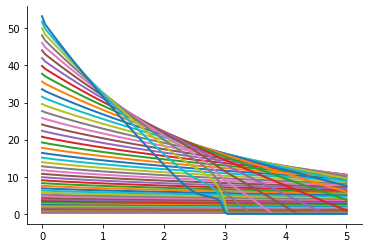

In [197]:
plt.plot(y_grid, res['ems'].T)
plt.show()

In [198]:
θ = 3
ϑ_bar = ϑ_1
λ_bar = λ_1
I_g = I_g_1
arg_list_tech1 = []
for i in range(len(γ3_list)):
    econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
    dmg_param = (γ1, γ2, γ3_list[i], y_bar)
    climate_param = (θ_list, σy)
    uncertain_param = (100_000, 100_000, 100_000)
    v_tech2_i = res_tech2[i]['v0']
    args = (econ_param, dmg_param, climate_param, uncertain_param)
    args_func = (y_grid, k_grid, args, False, v_tech2_i, None, 2, 1e-6,
                 2_000)
    arg_list_tech1.append(args_func)

res_tech1 = solve_parallel(arg_list_tech1, solve_postdmg)

Ep: 292; PDE Err: 0.005202496622; ft Err: 0.000000998913; Iter: 33; CG Err:0.000000000097
Ep: 296; PDE Err: 0.005531795488; ft Err: 0.000000989512; Iter: 32; CG Err:0.000000000097
Ep: 317; PDE Err: 0.003844526985; ft Err: 0.000000988445; Iter: 25; CG Err:0.000000000099
Ep: 284; PDE Err: 0.002541703160; ft Err: 0.000000998665; Iter: 37; CG Err:0.000000000097
Ep: 286; PDE Err: 0.003267304496; ft Err: 0.000000990874; Iter: 34; CG Err:0.000000000099
Ep: 315; PDE Err: 0.004381839804; ft Err: 0.000000992883; Iter: 26; CG Err:0.000000000099
Ep: 304; PDE Err: 0.005819918699; ft Err: 0.000000998697; Iter: 29; CG Err:0.000000000094
Ep: 289; PDE Err: 0.004824973388; ft Err: 0.000000997478; Iter: 34; CG Err:0.000000000098
Ep: 311; PDE Err: 0.006090957221; ft Err: 0.000000998343; Iter: 26; CG Err:0.000000000097
Ep: 759; PDE Err: 0.001792915422; ft Err: 0.000000981493; Iter: 27; CG Err:0.000000000099


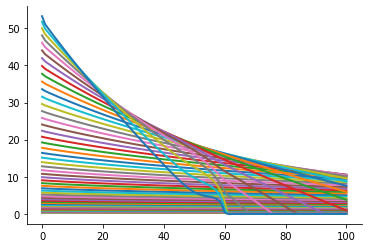

In [199]:
# plt.plot(res_tech1[0]['ems'][:, 33])
plt.plot(res_tech1[0]['ems'].T)
plt.show()

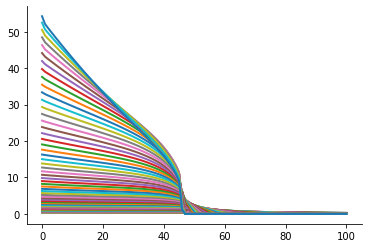

In [200]:
# plt.plot(res_tech1[0]['ems'][:, 33])
plt.plot(res_tech1[-1]['ems'].T)
plt.show()

## Step 3:

post damage,

pre 1st tech jump:

$\vartheta = 0.0453$ and $\lambda = 0.1206$, $\phi_m^{(0)}$

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)
\end{aligned}
$$

In [201]:
θ = 3
ϑ_bar = ϑ_0
λ_bar = λ_0
I_g = I_g_0
arg_list_tech0 = []
for i in range(len(γ3_list)):
    γ3_i = γ3_list[i]
    v_tech_i = res_tech1[i]['v0']
    econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
    dmg_param = (γ1, γ2, γ3_i, y_bar)
    climate_param = (θ_list, σy)
    uncertain_param = (100_000, 100_000, 100_000)
    args = (econ_param, dmg_param, climate_param, uncertain_param)
    args_func = (y_grid, k_grid, args, False, v_tech_i, v_tech_i, 2, 1e-6,
                 2_000)
    arg_list_tech0.append(args_func)

res_tech0 = solve_parallel(arg_list_tech0, solve_postdmg)

Ep: 351; PDE Err: 0.007584242313; ft Err: 0.000000978497; Iter: 35; CG Err:0.000000000097
Ep: 363; PDE Err: 0.008915821487; ft Err: 0.000000997375; Iter: 19; CG Err:0.000000000096
Ep: 320; PDE Err: 0.005302845850; ft Err: 0.000000980437; Iter: 65; CG Err:0.000000000098
Ep: 398; PDE Err: 0.010716659573; ft Err: 0.000000973155; Iter: 12; CG Err:0.000000000083
Ep: 398; PDE Err: 0.010152452728; ft Err: 0.000000981701; Iter: 14; CG Err:0.000000000087
Ep: 381; PDE Err: 0.008322769654; ft Err: 0.000000999078; Iter: 14; CG Err:0.000000000092
Ep: 417; PDE Err: 0.011215911989; ft Err: 0.000000999919; Iter: 10; CG Err:0.000000000084
Ep: 431; PDE Err: 0.009520627832; ft Err: 0.000000993765; Iter: 12; CG Err:0.000000000089
Ep: 540; PDE Err: 0.003856042883; ft Err: 0.000000990680; Iter: 63; CG Err:0.000000000099
Ep: 659; PDE Err: 0.006622402213; ft Err: 0.000000998499; Iter: 9; CG Err:0.000000000072


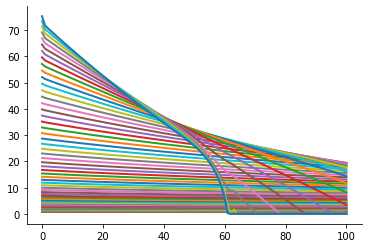

In [202]:
plt.plot(res_tech0[0]['ems'].T)
plt.show()

## Step 4: Pre damage,  post 2nd tech jump


$\vartheta = 0$,  $\lambda = 0.0798$, $\Phi^{(2)}$

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \Phi^{(2)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)\\
& + \mathcal{I}(y) \sum \pi_d^m (\phi_m^{(2)}(y, \log k) - \phi(y, \log k)) \\
& + \xi_p \mathcal{I} \sum \pi_d (1 - g + g \log g)
\end{aligned}
$$


In [203]:
def solve_predmg(y_grid,
                 k_grid,
                 args,
                 post_tech=True,
                 v_tech=None,
                 v_pre=None,
                 v0=None,
                 ϵ=2,
                 tol=1e-6,
                 max_iter=2_000):

    (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar,
     I_g), (γ1, γ2, γ3_list, πd_o_list, y_bar), (θ_list, σy), (ξa, ξp,
                                                               ξg) = args
    loc25 = np.abs(y_grid - 2.5).argmin()
    y_grid_cap = y_grid[:loc25 + 1]
    n_y = len(y_grid_cap)
    n_k = len(k_grid)
    dy = y_grid_cap[1] - y_grid_cap[0]
    dk = k_grid[1] - k_grid[0]

    (k_mat_cap, y_mat_cap) = np.meshgrid(k_grid, y_grid_cap, indexing='ij')
    stateSpace = np.hstack([
        k_mat_cap.reshape(-1, 1, order='F'),
        y_mat_cap.reshape(-1, 1, order='F')
    ])

    πa_o = np.ones((len(θ_list), n_k, n_y)) / len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_k, n_y))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o

    πd_o = np.zeros((len(γ3_list), n_k, n_y))
    for i in range(len(γ3_list)):
        πd_o[i] = πd_o_list[i]

    dΛ = γ1 + γ2 * y_mat_cap
    ddΛ = γ2
    numy_bar = len(y_grid_cap) - 1
    v_tech_cap = v_tech[:, :, :loc25 + 1]
    if v_pre is not None:
        v_pre_cap = v_pre[:, :loc25 + 1]

    r1 = 1.5
    r2 = 2.5

    y_lower = 1.8
    I_y = r1 * (np.exp(r2 / 2 *
                       (y_mat_cap - y_lower)**2) - 1) * (y_mat_cap >= y_lower)
    # ϕ_m(ȳ):
    loc_bar = np.abs(y_grid_cap - y_bar).argmin()
    ϕ_ref = np.zeros((len(γ3_list), n_k, n_y))
    for i in range(len(γ3_list)):
        for j in range(n_k):
            ϕ_ref[i, j] = v_tech[i, j, loc_bar]

    if v0 is None:
        ϕ = np.average(v_tech_cap, axis=0, weights=πd_o_list)
    else:
        ϕ = v0
    v_average = np.average(np.exp(-1 / ξp * v_tech),
                           weights=dmg_weight,
                           axis=0)
    ϕ_bound = -ξp * np.log(v_average)

    ϕ_dk = derivatives_2d(ϕ, 0, 1, dk)
    ems = 0 * np.ones(y_mat_cap.shape)
    # initial i
    a_i = κ * ϕ_dk
    b_i = -(1 + α * κ) * ϕ_dk
    c_i = α * ϕ_dk - 1
    i = (-b_i - np.sqrt(b_i**2 - 4 * a_i * c_i)) / (2 * a_i)
    mc = 1 / (α - i - α * ϑ_bar * (1 - ems /
                                   (np.exp(k_mat_cap) * α * λ_bar))**θ)

    episode = 0
    lhs_error = 1

    vd = -1 / δ
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        ϕ_dk = derivatives_2d(ϕ, 0, 1, dk)
        ϕ_dkk = derivatives_2d(ϕ, 0, 2, dk)
        ϕ_dy = derivatives_2d(ϕ, 1, 1, dy)
        ϕ_dyy = derivatives_2d(ϕ, 1, 2, dy)
        # update control
        # updating controls
        i_new = (1 - mc / ϕ_dk) * (1 / κ)
        #     update emission
        if θ == 2 or ϑ_bar == 0:
            a = ϕ_dyy*σy**2 + vd*ddΛ*σy**2 - mc * \
                θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat_cap))
            b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat_cap)) + ϕ_dy*np.sum(θ_mat*πa, axis=0) \
                + vd*dΛ*np.sum(θ_mat*πa, axis=0)
            ems_new = -b / a
        elif θ == 3:
            a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap)) / \
                (α**2*λ_bar**2*np.exp(2*k_mat_cap))
            b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))*2 / \
                (α*λ_bar*np.exp(k_mat_cap)) + (ϕ_dyy + vd*ddΛ)*σy**2
            c = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap)) + \
                (ϕ_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
            Δ = b**2 - 4 * a * c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ)) / (2 * a)
            root2 = (-b + np.sqrt(Δ)) / (2 * a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2
        ems_new[ems_new <= 0] = 1e-8
        i_new = i_new * 0.02 + i * 0.98
        ems_new = ems_new * 0.02 + ems * 0.98
        ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap))) * \
            ((1 - ems_new/(α*λ_bar*np.exp(k_mat_cap))) > 0)
        #     ratio[ratio > 1] = 1
        consumption = α - i_new - α * ϑ_bar * ratio**θ
        mc_new = 1 / consumption
        #     mc_new[mc_new <= 1e-15] = 1e-15
        #     mc_new = mc_new*0.05 + mc*0.95
        temp = ϕ_dy + vd * dΛ
        weight = np.array([-1 / ξa * temp * ems_new * θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o * np.exp(weight)
        πa[πa <= 0] = 1e-15
        πa = πa / np.sum(πa, axis=0)
        #         print("min ems:", np.min(ems_new))
        #         print("min mc", np.min(mc_new))
        # HJB coefficient

        g_dmg = np.exp(1 / ξp * (ϕ - ϕ_ref))
        entropy = np.sum(πa * (np.log(πa) - np.log(πa_o)), axis=0)
        #         A = -δ*np.ones(y_mat_cap.shape) - I_y*np.sum(g_dmg*πd_o, axis=0) - I_g*
        B_y = np.sum(θ_mat * πa, axis=0) * ems_new
        B_k = μk + i_new - 0.5 * κ * i_new**2 - 0.5 * σk**2
        C_yy = 0.5 * ems_new**2 * σy**2
        C_kk = 0.5 * σk**2 * np.ones(y_mat_cap.shape)
        if post_tech:
            A = -δ * np.ones(y_mat_cap.shape) - I_y * np.sum(g_dmg * πd_o,
                                                             axis=0)
            D = np.log(consumption) + k_mat_cap + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) + \
                ξa*entropy + I_y*np.sum(πd_o*(g_dmg*ϕ_ref), axis=0) + ξp * \
                I_y*np.sum(πd_o*(1 - g_dmg + g_dmg*np.log(g_dmg)), axis=0)
        else:
            g_tech = np.exp(1 / ξg * (ϕ - v_pre_cap))
            A = -δ*np.ones(y_mat_cap.shape) - I_y *\
                np.sum(g_dmg*πd_o, axis=0) - I_g*g_tech
            D = np.log(consumption) + k_mat_cap + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new \
                + 0.5*ddΛ*σy**2*ems_new**2) + ξa*entropy + I_y*np.sum(πd_o*(g_dmg*ϕ_ref), axis=0) \
                + ξp * I_y*np.sum(πd_o*(1 - g_dmg + g_dmg*np.log(g_dmg)), axis=0) + \
                I_g*g_tech*v_pre_cap + ξg*I_g * \
                (1 - g_tech + g_tech*np.log(g_tech))
        # PDE solver
        out = PDESolver_2d(stateSpace,
                           A,
                           B_k,
                           B_y,
                           C_kk,
                           C_yy,
                           D,
                           ϕ,
                           ϵ,
                           solverType='False Transient')
        out_comp = out[2].reshape(ϕ.shape, order="F")
        rhs = A * ϕ + B_y * ϕ_dy + B_k * ϕ_dk + C_yy * ϕ_dyy + C_kk * ϕ_dkk + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - ϕ) / ϵ))
        #     if episode % 1 == 0:

        episode += 1
        ϕ = out_comp
        ems = ems_new
        mc = mc_new
        i = i_new

        print(
            "Episode: {:d} pde err: {:.12f}; ft err: {:.12f}; Iterations: {:d}; cg err: {:.12f}"
            .format(episode, rhs_error, lhs_error, out[0], out[1]))
    solution = dict(
        v0=ϕ,
        ems=ems,
        inv=i,
        g_dmg=g_dmg,
        πa=πa,
        v_bound=ϕ_bound,
    )
    return solution

In [204]:
θ = 3
ϑ_bar = 0
λ_bar = λ_1
I_g = I_g_1
πd_o_list = np.ones(len(γ3_list))/len(γ3_list)
econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
dmg_param = (γ1, γ2, γ3_list, πd_o_list, y_bar)
climate_param = (θ_list, σy)
uncertain_param = (100_000, 100_000, 100_000)
v_tech = np.zeros((len(res_tech2), n_k, n_y))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech2)):
    v_tech[i] = res_tech2[i]['v0']
res_tech2_prd = solve_predmg(y_grid, k_grid, args,
                             True, v_tech, None, None, 2, 1e-6, 2_000)

Episode: 1 pde err: 0.000001044042; ft err: 0.000001111176; Iterations: 2; cg err: 0.000000000100
Episode: 2 pde err: 0.000001032850; ft err: 0.000001151681; Iterations: 2; cg err: 0.000000000072
Episode: 3 pde err: 0.000001064490; ft err: 0.000001174122; Iterations: 2; cg err: 0.000000000050
Episode: 4 pde err: 0.000001079853; ft err: 0.000001184687; Iterations: 2; cg err: 0.000000000041
Episode: 5 pde err: 0.000001088174; ft err: 0.000001188903; Iterations: 2; cg err: 0.000000000037
Episode: 6 pde err: 0.000001092293; ft err: 0.000001189324; Iterations: 2; cg err: 0.000000000035
Episode: 7 pde err: 0.000001093546; ft err: 0.000001187271; Iterations: 2; cg err: 0.000000000033
Episode: 8 pde err: 0.000001092717; ft err: 0.000001183492; Iterations: 2; cg err: 0.000000000032
Episode: 9 pde err: 0.000001090302; ft err: 0.000001178424; Iterations: 2; cg err: 0.000000000031
Episode: 10 pde err: 0.000001086626; ft err: 0.000001172330; Iterations: 2; cg err: 0.000000000031
Episode: 11 pde err

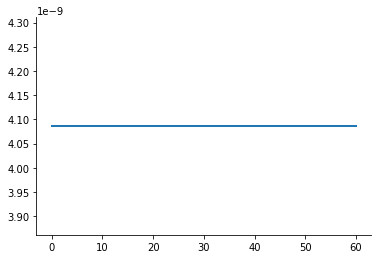

In [205]:
plt.plot(res_tech2_prd['ems'])
plt.show()

## Step 5: Pre damage,  post 1st tech jump, pre 2nd tech jump

$\vartheta = 0.0260$,  $\lambda = 0.0798$, $\Phi^{(1)}$


$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \Phi^{(1)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)\\
& + \mathcal{I}(y) \sum g \pi_d^m  (\phi_m^{(1)}(y, \log k) - \Phi^{(1)}(y, \log k)) \\
& + \xi_p \mathcal{I}(y) \sum \pi_d^m (1 - g + g \log g)\\
& + \mathcal{I}_g \sum (\Phi^{(2)}(y, \log k) - \Phi^{(1)}(y, \log k)) \\
& + \xi_p \mathcal{I}_g \sum \pi_d (1 - g + g \log g)
\end{aligned}
$$


In [206]:
ϑ_bar = ϑ_1
λ_bar = λ_1
I_g = I_g_1
πd_o_list = np.ones(len(γ3_list)) / len(γ3_list)
econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
dmg_param = (γ1, γ2, γ3_list, πd_o_list, y_bar)
climate_param = (θ_list, σy)
uncertain_param = (100_000, 100_000, 100_000)
v_tech = np.zeros((len(res_tech1), n_k, n_y))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech1)):
    v_tech[i] = res_tech1[i]['v0']
v_pre = res_tech2_prd['v0']
res_tech1_prd = solve_predmg(y_grid, k_grid, args, False, v_tech, v_pre, None,
                             2, 1e-6, 4_000)

Episode: 1 pde err: 0.427832295574; ft err: 0.117830057515; Iterations: 11; cg err: 0.000000000093
Episode: 2 pde err: 0.122811358091; ft err: 0.078770748241; Iterations: 12; cg err: 0.000000000039
Episode: 3 pde err: 0.072693236124; ft err: 0.066084469280; Iterations: 12; cg err: 0.000000000089
Episode: 4 pde err: 0.060528045027; ft err: 0.055025019859; Iterations: 13; cg err: 0.000000000093
Episode: 5 pde err: 0.049918671373; ft err: 0.045386116494; Iterations: 15; cg err: 0.000000000049
Episode: 6 pde err: 0.040649034216; ft err: 0.036990818479; Iterations: 16; cg err: 0.000000000061
Episode: 7 pde err: 0.032575462911; ft err: 0.029685290236; Iterations: 17; cg err: 0.000000000077
Episode: 8 pde err: 0.025571396867; ft err: 0.023336111565; Iterations: 18; cg err: 0.000000000078
Episode: 9 pde err: 0.019490700653; ft err: 0.017826006552; Iterations: 17; cg err: 0.000000000050
Episode: 10 pde err: 0.014221513590; ft err: 0.013053432563; Iterations: 21; cg err: 0.000000000063
Episode: 

Episode: 85 pde err: 0.002870637437; ft err: 0.001188780843; Iterations: 79; cg err: 0.000000000100
Episode: 86 pde err: 0.002885575944; ft err: 0.001129759986; Iterations: 83; cg err: 0.000000000080
Episode: 87 pde err: 0.002900040230; ft err: 0.001073633977; Iterations: 77; cg err: 0.000000000099
Episode: 88 pde err: 0.002914052720; ft err: 0.001020198069; Iterations: 81; cg err: 0.000000000082
Episode: 89 pde err: 0.002927633917; ft err: 0.000969459518; Iterations: 77; cg err: 0.000000000098
Episode: 90 pde err: 0.002940796379; ft err: 0.000921281021; Iterations: 77; cg err: 0.000000000096
Episode: 91 pde err: 0.002953556722; ft err: 0.000875508152; Iterations: 77; cg err: 0.000000000095
Episode: 92 pde err: 0.002965929650; ft err: 0.000832015522; Iterations: 77; cg err: 0.000000000095
Episode: 93 pde err: 0.002977929333; ft err: 0.000790699524; Iterations: 77; cg err: 0.000000000094
Episode: 94 pde err: 0.002989569276; ft err: 0.000751459971; Iterations: 77; cg err: 0.000000000097


Episode: 169 pde err: 0.003354542472; ft err: 0.000023729346; Iterations: 56; cg err: 0.000000000099
Episode: 170 pde err: 0.003356189047; ft err: 0.000022715979; Iterations: 56; cg err: 0.000000000097
Episode: 171 pde err: 0.003357801824; ft err: 0.000021746902; Iterations: 55; cg err: 0.000000000099
Episode: 172 pde err: 0.003359378078; ft err: 0.000020820610; Iterations: 55; cg err: 0.000000000095
Episode: 173 pde err: 0.003360920006; ft err: 0.000019931897; Iterations: 54; cg err: 0.000000000099
Episode: 174 pde err: 0.003362428650; ft err: 0.000019098369; Iterations: 54; cg err: 0.000000000096
Episode: 175 pde err: 0.003363903312; ft err: 0.000018301395; Iterations: 53; cg err: 0.000000000099
Episode: 176 pde err: 0.003365342052; ft err: 0.000017538068; Iterations: 53; cg err: 0.000000000097
Episode: 177 pde err: 0.003366751730; ft err: 0.000016804031; Iterations: 53; cg err: 0.000000000095
Episode: 178 pde err: 0.003368130423; ft err: 0.000016111912; Iterations: 52; cg err: 0.000

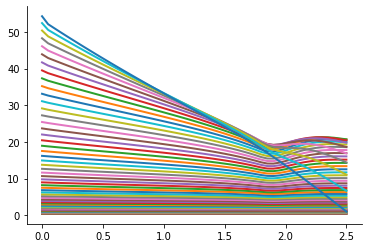

In [207]:
y_grid_cap = y_grid[:len(res_tech1_prd['ems'].T)]
plt.plot(y_grid_cap, res_tech1_prd['ems'].T)
plt.show()

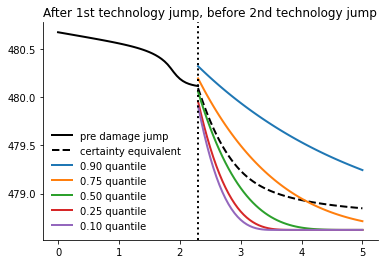

In [208]:
loc_k0 = np.abs(np.exp(k_grid) - k0).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v = res_tech1_prd['v0']
v_bound = res_tech1_prd['v_bound']
plt.plot(y_grid[:loc_bar+1], v[loc_k0, :loc_bar + 1],
         color='black', label="pre damage jump")
plt.plot(y_grid[loc_bar:], v_bound[loc_k0, loc_bar:],
         color='black', linestyle='dashed', label='certainty equivalent')
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]
v_tech = np.zeros((len(res_tech1), n_k, n_y))
for i in range(len(res_tech1)):
    v_tech[i] = res_tech1[i]['v0']
for i in range(len(quantile_list)):
    plt.plot(y_grid[loc_bar:], np.quantile(v_tech[:, loc_k0, loc_bar:, ], quantile_list[4-i], axis=0),
             label="{:.2f} quantile".format(quantile_list[4-i]))

plt.axvline(y_bar, color='black', linestyle=':')
plt.title('After 1st technology jump, before 2nd technology jump')
plt.legend()
# plt.xlim(0.3, 4)
# plt.savefig('../figures/DICE_like/Phi_1.png', dpi=300)

In [209]:
v[loc_k0, loc_bar,], v_bound[loc_k0,loc_bar]

(480.1184308491002, 480.09724655615327)

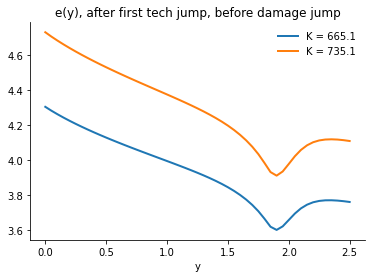

In [210]:
e = res_tech1_prd['ems']
plt.plot(y_grid_cap, e[loc_k0], label="K = {:.1f}".format(np.exp(k_grid[loc_k0])))
plt.plot(y_grid_cap, e[loc_k0+1], label="K = {:.1f}".format(np.exp(k_grid[loc_k0+1])))
plt.legend()
plt.title('e(y), after first tech jump, before damage jump')
plt.xlabel('y')
# plt.savefig('../figures/DICE_like/e_y.png', dpi=300)
plt.show()

## Step 6: Pre damage,  pre 1nd tech jump

$\vartheta = 0.0453$,  $\lambda = 0.1206$, $\Phi^{(0)}$


$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \Phi^{(0)}(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)\\
& + \mathcal{I}(y) \sum g \pi_d^m  (\phi_m^{(1)}(y, \log k) - \Phi^{(0)}(y, \log k)) \\
& + \xi_p \mathcal{I}(y) \sum \pi_d^m (1 - g + g \log g)\\
& + \mathcal{I}_g \sum (\Phi^{(1)}(y, \log k) - \Phi^{(0)}(y, \log k)) \\
& + \xi_p \mathcal{I}_g \sum \pi_d (1 - g + g \log g)
\end{aligned}
$$


In [211]:
ϑ_bar = ϑ_0
λ_bar = λ_0
I_g = I_g_0
πd_o_list = np.ones(len(γ3_list)) / len(γ3_list)
econ_param = (δ, η, α, μk, σk, κ, θ, ϑ_bar, λ_bar, I_g)
dmg_param = (γ1, γ2, γ3_list, πd_o_list, y_bar)
climate_param = (θ_list, σy)
uncertain_param = (100_000, 100_000, 100_000)
v_tech = np.zeros((len(res_tech0), n_k, n_y))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech1)):
    v_tech[i] = res_tech0[i]['v0']
v_pre = res_tech1_prd['v0']
res_tech0_prd = solve_predmg(y_grid, k_grid, args, False, v_tech, v_pre, None,
                             2, 1e-6, 1_000)

Episode: 1 pde err: 0.853821722940; ft err: 0.235280005526; Iterations: 12; cg err: 0.000000000079
Episode: 2 pde err: 0.248190587334; ft err: 0.163590270401; Iterations: 14; cg err: 0.000000000037
Episode: 3 pde err: 0.149567219723; ft err: 0.135969065411; Iterations: 16; cg err: 0.000000000054
Episode: 4 pde err: 0.123538118160; ft err: 0.112273103192; Iterations: 18; cg err: 0.000000000083
Episode: 5 pde err: 0.101093626710; ft err: 0.091883952458; Iterations: 21; cg err: 0.000000000086
Episode: 6 pde err: 0.081690811424; ft err: 0.074315082282; Iterations: 24; cg err: 0.000000000084
Episode: 7 pde err: 0.064910977841; ft err: 0.059168552948; Iterations: 27; cg err: 0.000000000073
Episode: 8 pde err: 0.050402514463; ft err: 0.046107525163; Iterations: 29; cg err: 0.000000000066
Episode: 9 pde err: 0.037867426877; ft err: 0.034843666341; Iterations: 32; cg err: 0.000000000093
Episode: 10 pde err: 0.027108123369; ft err: 0.025138619052; Iterations: 37; cg err: 0.000000000079
Episode: 

Episode: 88 pde err: 0.008438530198; ft err: 0.001956651408; Iterations: 146; cg err: 0.000000000097
Episode: 89 pde err: 0.008467351235; ft err: 0.001856947755; Iterations: 149; cg err: 0.000000000087
Episode: 90 pde err: 0.008495370473; ft err: 0.001762260260; Iterations: 150; cg err: 0.000000000092
Episode: 91 pde err: 0.008522604431; ft err: 0.001672358108; Iterations: 147; cg err: 0.000000000096
Episode: 92 pde err: 0.008549081289; ft err: 0.001587088336; Iterations: 150; cg err: 0.000000000093
Episode: 93 pde err: 0.008574833397; ft err: 0.001506359126; Iterations: 146; cg err: 0.000000000099
Episode: 94 pde err: 0.008599876077; ft err: 0.001429821595; Iterations: 147; cg err: 0.000000000097
Episode: 95 pde err: 0.008624236242; ft err: 0.001357210518; Iterations: 151; cg err: 0.000000000088
Episode: 96 pde err: 0.008647941714; ft err: 0.001288373513; Iterations: 151; cg err: 0.000000000084
Episode: 97 pde err: 0.008671005208; ft err: 0.001223109288; Iterations: 146; cg err: 0.000

Episode: 173 pde err: 0.009525499749; ft err: 0.000036544211; Iterations: 94; cg err: 0.000000000099
Episode: 174 pde err: 0.009529689675; ft err: 0.000034983784; Iterations: 94; cg err: 0.000000000099
Episode: 175 pde err: 0.009533787734; ft err: 0.000033485994; Iterations: 93; cg err: 0.000000000100
Episode: 176 pde err: 0.009537800592; ft err: 0.000032057151; Iterations: 92; cg err: 0.000000000097
Episode: 177 pde err: 0.009541719270; ft err: 0.000030693984; Iterations: 80; cg err: 0.000000000098
Episode: 178 pde err: 0.009545556738; ft err: 0.000029385652; Iterations: 80; cg err: 0.000000000094
Episode: 179 pde err: 0.009549310889; ft err: 0.000028133402; Iterations: 80; cg err: 0.000000000093
Episode: 180 pde err: 0.009552982089; ft err: 0.000026934478; Iterations: 78; cg err: 0.000000000099
Episode: 181 pde err: 0.009556582167; ft err: 0.000025786058; Iterations: 78; cg err: 0.000000000097
Episode: 182 pde err: 0.009560095719; ft err: 0.000024687096; Iterations: 78; cg err: 0.000

Episode: 261 pde err: 0.009691771105; ft err: 0.000001719158; Iterations: 37; cg err: 0.000000000095
Episode: 262 pde err: 0.009692398938; ft err: 0.000001679559; Iterations: 37; cg err: 0.000000000099
Episode: 263 pde err: 0.009693017617; ft err: 0.000001655865; Iterations: 36; cg err: 0.000000000098
Episode: 264 pde err: 0.009693619946; ft err: 0.000001636567; Iterations: 35; cg err: 0.000000000100
Episode: 265 pde err: 0.009694207153; ft err: 0.000001588519; Iterations: 35; cg err: 0.000000000098
Episode: 266 pde err: 0.009694789490; ft err: 0.000001546018; Iterations: 35; cg err: 0.000000000095
Episode: 267 pde err: 0.009695362326; ft err: 0.000001509520; Iterations: 35; cg err: 0.000000000093
Episode: 268 pde err: 0.009695924567; ft err: 0.000001488929; Iterations: 34; cg err: 0.000000000099
Episode: 269 pde err: 0.009696476630; ft err: 0.000001476095; Iterations: 33; cg err: 0.000000000096
Episode: 270 pde err: 0.009697021654; ft err: 0.000001407886; Iterations: 34; cg err: 0.000

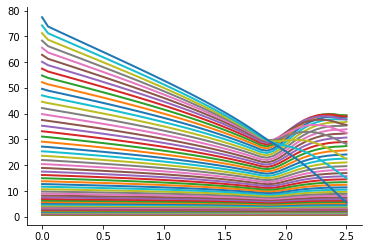

In [212]:
plt.plot(y_grid_cap, res_tech0_prd['ems'].T)
plt.show()

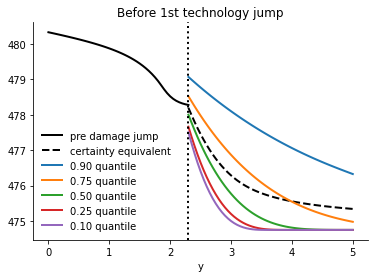

In [213]:
loc_k0 = np.abs(np.exp(k_grid) - k0).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v = res_tech0_prd['v0']
v_bound = res_tech0_prd['v_bound']
plt.plot(y_grid[:loc_bar+1], v[loc_k0, :loc_bar+1],
         color='black', label="pre damage jump")
plt.plot(y_grid[loc_bar:], v_bound[loc_k0, loc_bar:],
         color='black', linestyle='--', label='certainty equivalent')
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]
v_tech = np.zeros((len(res_tech0), n_k, n_y))
args = (econ_param, dmg_param, climate_param, uncertain_param)
for i in range(len(res_tech1)):
    v_tech[i] = res_tech0[i]['v0']
for i in range(len(quantile_list)):
    plt.plot(y_grid[loc_bar:], np.quantile(v_tech[:, loc_k0, loc_bar:, ], quantile_list[4-i], axis=0),
             label="{:.2f} quantile".format(quantile_list[4-i]))

plt.axvline(y_bar, color='black', linestyle=':')
plt.title('Before 1st technology jump')
plt.xlabel('y')
plt.legend(loc=3)
# plt.savefig('../figures/DICE_like/Phi_0.png', dpi=300)

In [214]:
v[loc_k0, loc_bar], v_bound[loc_k0, loc_bar]

(478.27536086473464, 478.1952102609148)

Text(0.5, 1.0, 'Pre damage jump, ϕ, K = 665.14')

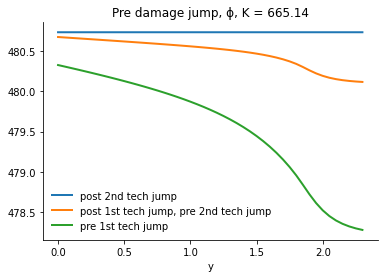

In [215]:
loc_k0 = np.abs(np.exp(k_grid) - k0).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v0 = res_tech0_prd['v0']
v1 = res_tech1_prd['v0']
v2 = res_tech2_prd['v0']

plt.plot(y_grid[:loc_bar+1], v2[loc_k0, :loc_bar+1], label="post 2nd tech jump")
plt.plot(y_grid[:loc_bar+1], v1[loc_k0, :loc_bar+1], label="post 1st tech jump, pre 2nd tech jump")
plt.plot(y_grid[:loc_bar+1], v0[loc_k0, :loc_bar+1], label="pre 1st tech jump")
plt.legend(loc=3)
plt.xlabel('y')
plt.title('Pre damage jump, ϕ, K = {:.2f}'.format(np.exp(k_grid[loc_k0])))
# plt.savefig('../figures/DICE_like/tech_jump.png', dpi=300)

Text(0.5, 1.0, 'Pre damage jump, emission, K = 1211.97')

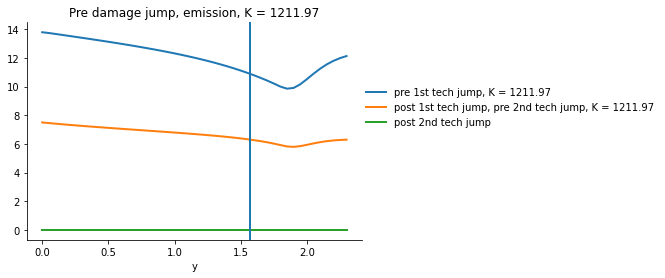

In [216]:
# 1
k = 1256
loc_k0 = np.abs(np.exp(k_grid) - k).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v0 = res_tech0_prd['ems']
v1 = res_tech1_prd['ems']
v2 = res_tech2_prd['ems']

plt.plot(y_grid[:loc_bar + 1],
         v0[loc_k0, :loc_bar + 1],
         label="pre 1st tech jump, K = {:.2f}".format(np.exp(k_grid[loc_k0])))
plt.plot(y_grid[:loc_bar + 1],
         v1[loc_k0, :loc_bar + 1],
         label="post 1st tech jump, pre 2nd tech jump, K = {:.2f}".format(
             np.exp(k_grid[loc_k0])))
plt.plot(y_grid[:loc_bar + 1],
         v2[loc_k0, :loc_bar + 1],
         label="post 2nd tech jump")
plt.legend(loc=(1, 0.5))
plt.xlabel('y')
plt.axvline(1.57)
plt.title('Pre damage jump, emission, K = {:.2f}'.format(np.exp(k_grid[loc_k0])))
# plt.savefig('../figures/DICE_like/tech_jump.png', dpi=300)

Text(0.5, 1.0, 'Pre damage jump, emission, K = 1096.63')

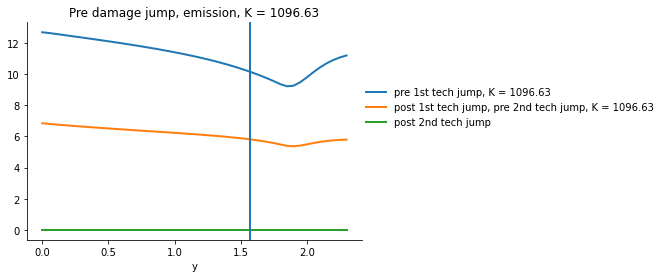

In [217]:
# 2
k = 1256
loc_k0 = np.abs(np.exp(k_grid) - k).argmin()
loc_bar = np.abs(y_grid - y_bar).argmin()
v0 = res_tech0_prd['ems']
v1 = res_tech1_prd['ems']
v2 = res_tech2_prd['ems']

plt.plot(y_grid[:loc_bar + 1],
         v0[loc_k0-1, :loc_bar + 1],
         label="pre 1st tech jump, K = {:.2f}".format(np.exp(k_grid[loc_k0-1])))
plt.plot(y_grid[:loc_bar + 1],
         v1[loc_k0-1, :loc_bar + 1],
         label="post 1st tech jump, pre 2nd tech jump, K = {:.2f}".format(
             np.exp(k_grid[loc_k0-1])))
plt.plot(y_grid[:loc_bar + 1],
         v2[loc_k0, :loc_bar + 1],
         label="post 2nd tech jump")
plt.legend(loc=(1, 0.5))
plt.xlabel('y')
plt.axvline(1.57)
plt.title('Pre damage jump, emission, K = {:.2f}'.format(np.exp(k_grid[loc_k0-1])))
# plt.savefig('../figures/DICE_like/tech_jump.png', dpi=300)

# Simulation


Damage jump probability: $\mathcal{I}(y) dt$;

Technology jump probability: $\mathcal{I}_g dt$

## No jump simulation

In [654]:
t_tech_jump1 = 25
t_tech_jump2 = 50
I_g_1 = 1 / 25
I_g_2 = 1 / 25
res = res_tech0_prd
r1 = 1.5
r2 = 2.5
y = 1.1
T = 100
dt = 1

nDims = 6
# ems = res['ems']
# inv = res['inv']
ems0 = res_tech0_prd['ems']
inv0 = res_tech0_prd['inv']
ems1 = res_tech1_prd['ems']
inv1 = res_tech1_prd['inv']
ems2 = res_tech2_prd['ems']
inv2 = res_tech2_prd['inv']
y_grid_cap = y_grid[:len(ems0.T)]
y_lower = 1.8
pers = int(T / dt)
gridpoints = (k_grid, y_grid_cap)
gridpoints_long = (k_grid, y_grid)


# interpolate emission
# interpolate emission
# e_func_r = GridInterp_2d(gridpoints, ems0, 'Linear')
def e_func(x, ems, pre=True):
    if pre:
        e_interp = GridInterp_2d(gridpoints, ems, 'Linear')
    else:
        e_interp = GridInterp_2d(gridpoints_long, ems, 'Linear')
    return e_interp.get_value(x[1], x[0])  # match order


# interpolate investment
# i_func_r = GridInterp_2d(gridpoints, inv, 'Linear')
def i_func(x, inv, pre=True):
    if pre:
        i_func_r = GridInterp_2d(gridpoints, inv, 'Linear')
    else:
        i_func_r = GridInterp_2d(gridpoints_long, inv, 'Linear')
    return i_func_r.get_value(x[1], x[0])


# drifts for each diffusion process
def compute_μlogk(x, inv, pre=True):
    return μk + i_func(x, inv,
                       pre) - 0.5 * κ * i_func(x, inv, pre)**2 - 0.5 * σk**2


def compute_μy(E_x):
    return E_x * np.mean(θ_list)


def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2 * Y_x
    ddΛ = γ2
    return dΛ * compute_μy(E_x) + 0.5 * ddΛ * σy**2 * E_x**2


# initial points
K_0 = 80 / α
Y_0 = 1.1
logD_0 = γ1 * Y_0 + 0.5 * γ2 * Y_0**2

tech_state = 0
hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])
prob_hist = np.zeros([pers])

# initial points
iota_0 = 0
ME_0 = 0
J_0 = 0
hist[0, :] = [Y_0, np.log(K_0), logD_0, iota_0, ME_0, J_0]
e_hist[0] = e_func(hist[0, :], ems0)
i_hist[0] = i_func(hist[0, :], inv0)
iota_0 = 1 - e_hist[0] / np.exp(hist[0, 1]) / (α * λ_0)
ME_0 = θ * ϑ_0 / λ_0 * iota_0**(θ - 1)
J_0 = ϑ_0 * iota_0**θ * α * K_0
hist[0, 3] = iota_0
hist[0, 4] = ME_0
hist[0, 5] = J_0

jump = True
ems_grid = ems0
inv_grid = inv0
t_dmg = t_tech_jump1
λ_bar = λ_0
ϑ_bar = ϑ_0
for tm in range(1, pers):
    # damage jump happens with 1 prob to one of damage function
    if hist[tm - 1, 0] >= y_bar:
        if hist[tm - 2, 0] < y_bar:
            t_dmg = tm
            print(t_dmg)
            break
    # other periods
    else:

        if tm == t_tech_jump1 and jump:
            ems_grid = ems1
            inv_grid = inv1
            λ_bar = λ_1
            ϑ_bar = ϑ_1
        elif tm == t_tech_jump2 and jump:
            ems_grid = ems2
            inv_grid = inv2
            λ_bar = λ_1
            ϑ_bar = ϑ_2

        e_hist[tm] = e_func(hist[tm - 1, :], ems_grid)
        i_hist[tm] = i_func(hist[tm - 1, :], inv_grid)
        hist[tm, 0] = hist[tm - 1, 0] + compute_μy(e_hist[tm - 1]) * dt  # Y
        hist[tm, 1] = hist[tm - 1, 1] + compute_μlogk(hist[tm - 1, :],
                                                      inv_grid) * dt  # logK
        hist[tm, 2] = hist[tm - 1, 2] + compute_μlogd(
            hist[tm - 1, :], e_hist[tm - 1]) * dt  # logDt
        hist[tm, 3] = 1 - e_hist[tm] / np.exp(hist[tm, 1]) / (α * λ_bar)
        hist[tm, 4] = θ * ϑ_bar / λ_bar * hist[tm, 3]**(θ - 1)
        hist[tm, 5] = ϑ_bar * hist[tm, 3]**θ * α * np.exp(hist[tm, 1])


ems_postdmg = np.zeros((pers - t_dmg, len(γ3_list)))
inv_postdmg = np.zeros((pers - t_dmg, len(γ3_list)))
hist_postdmg = np.zeros((pers - t_dmg, nDims, len(γ3_list)))
for tm in range(t_dmg, pers):
    if tm >= t_tech_jump1 and tm < t_tech_jump2:
        res_tech = res_tech1
    elif tm >= t_tech_jump2:
        res_tech = res_tech2
    # simulate
    for j in range(len(γ3_list)):
        ems_grid = res_tech[j]['ems']
        inv_grid = res_tech[j]['inv']
        if tm == t_dmg:
            ems_postdmg[tm - t_dmg, j] = e_func(hist[t_dmg - 1, :], ems_grid,
                                                False)
            inv_postdmg[tm - t_dmg, j] = i_func(hist[t_dmg - 1, :], inv_grid,
                                                False)
            hist_postdmg[tm - t_dmg, 0,
                         j] = hist[t_dmg - 1,
                                   0] + compute_μy(e_hist[t_dmg - 1]) * dt
            hist_postdmg[tm - t_dmg, 1,
                         j] = hist[t_dmg - 1, 1] + compute_μlogk(
                             hist[t_dmg - 1, :], inv_grid, False) * dt
            hist_postdmg[tm - t_dmg,
                         2, :] = hist[t_dmg - 1, 2] + compute_μlogd(
                             hist[t_dmg - 1, :], e_hist[t_dmg - 1]) * dt
        elif tm > t_dmg:
            ems_postdmg[tm - t_dmg,
                        j] = e_func(hist_postdmg[tm - t_dmg - 1, :, j],
                                    ems_grid, False)
            inv_postdmg[tm - t_dmg,
                        j] = i_func(hist_postdmg[tm - t_dmg - 1, :, j],
                                    inv_grid, False)
            hist_postdmg[tm - t_dmg, 0,
                         j] = hist_postdmg[tm - t_dmg - 1, 0, j] + compute_μy(
                             ems_postdmg[tm - t_dmg - 1, j]) * dt
            hist_postdmg[
                tm - t_dmg, 1,
                j] = hist_postdmg[tm - t_dmg - 1, 1, j] + compute_μlogk(
                    hist_postdmg[tm - t_dmg - 1, :, j], inv_grid, False) * dt
            hist_postdmg[tm - t_dmg, 2, j] = hist_postdmg[
                tm - t_dmg - 1, 2,
                j] + compute_μlogd(hist_postdmg[tm - t_dmg - 1, :, j],
                                   ems_postdmg[tm - t_dmg - 1, j]) * dt

simul = dict(
    e=e_hist,
    states=hist,
)

In [655]:
hist[:,0]

array([1.1       , 1.11455591, 1.12911182, 1.14388293, 1.1588676 ,
       1.17406741, 1.18949162, 1.20513715, 1.22100149, 1.23708144,
       1.25337605, 1.26989513, 1.28663508, 1.30359071, 1.32075868,
       1.33813736, 1.35573356, 1.3735433 , 1.39156133, 1.40978093,
       1.42819945, 1.44682287, 1.46564418, 1.48465826, 1.50385558,
       1.5232308 , 1.53437603, 1.54566821, 1.5571215 , 1.56873419,
       1.58050346, 1.59243747, 1.60453405, 1.61679096, 1.6292046 ,
       1.64177054, 1.65449722, 1.66738183, 1.68041977, 1.69360473,
       1.70693353, 1.7204136 , 1.73403793, 1.74779938, 1.761694  ,
       1.77571782, 1.7898688 , 1.80414102, 1.81852969, 1.83303342,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765

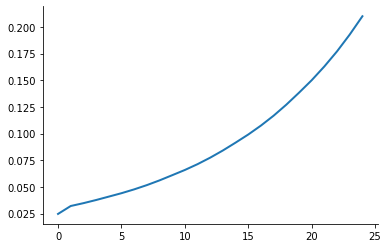

In [656]:
plt.plot(hist[:t_dmg, -1])

In [657]:
iota_post = 1 - ems_postdmg / np.exp(hist_postdmg[:, 1]) / (α * λ_bar)
MUe_post = θ * ϑ_bar / λ_bar * iota_post**(θ - 1)

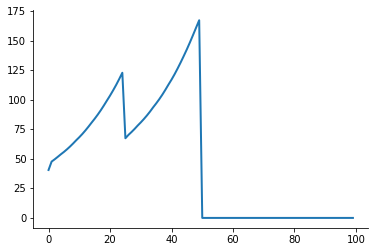

In [658]:
plt.plot((hist[:,-2]*1000))
# plt.plot(np.arange(t_dmg, pers), MUe_post*1000)
plt.show()

In [659]:
np.exp(hist[-1,1])

4998.573158244505

Text(0.5, 0, 'Years')

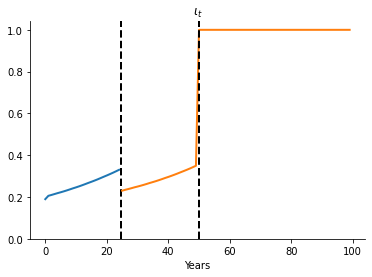

In [660]:
plt.plot(hist[:t_dmg, 3])
plt.axvline(x=t_tech_jump1 - 0.5, linestyle='dashed', color='black')
plt.plot(np.arange(t_dmg, pers), iota_post[:, 5])
plt.ylim(0)
plt.title(r'$ι_t$')
# plt.axvline(x=t_tech_jump1, linestyle='dashed', color='black')
# plt.axvline(x=t_dmg, linestyle='dashed', color='black')
plt.axvline(x=t_tech_jump2, linestyle='dashed', color='black')
plt.xlabel('Years')

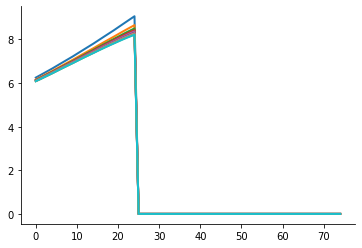

In [661]:
plt.plot(ems_postdmg)
plt.show()

Text(0.5, 0, 'Years')

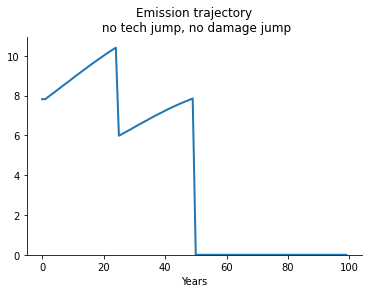

In [662]:
plt.plot(e_hist)
# plt.xlim(0, 73)
plt.ylim(0)
plt.title('Emission trajectory\n no tech jump, no damage jump')
plt.xlabel('Years')
# plt.savefig('../figures/DICE_like/Et_no_jump.png', dpi=300)

Text(0.5, 0, 'Years')

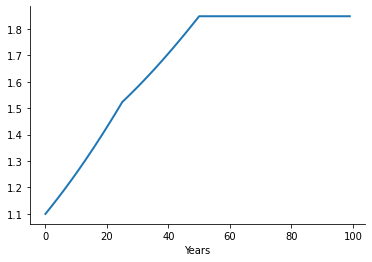

In [663]:
plt.plot(hist[:,0])
plt.xlabel('Years')

(0.0, 0.1)

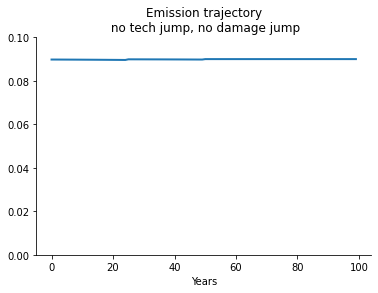

In [664]:
plt.plot(i_hist)
# plt.xlim(0, 74)
# plt.ylim(0)
plt.title('Emission trajectory\n no tech jump, no damage jump')
plt.xlabel('Years')
plt.ylim(0, 0.1)
# plt.savefig('../figures/DICE_like/Et_no_jump.png', dpi=300)

In [665]:
df = pd.DataFrame({
    'years': np.arange(0, len(e_hist)),
    'emission': e_hist,
    'investment': i_hist,
    'temp ano': hist[:, 0],
    'iota': hist[:, 3],
    'ems loss': 1  - hist[:,3],
    'SCC': hist[:, -1]*1000
})

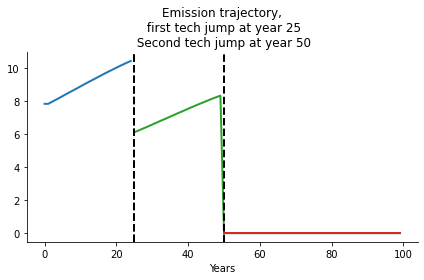

In [666]:
# emission
plt.plot(
    'years',
    'emission',
    data=df[df['years'] < t_tech_jump1],
)

plt.plot(
    'years',
    'emission',
    data=df[(df['years'] >= t_tech_jump1) & (df['years'] < t_dmg)],
)

plt.plot(np.arange(t_dmg, pers), ems_postdmg[:, 5])
# plt.plot(
#     'years',
#     'emission',
#     data=df[(df['years'] >= t_tech_jump2-1) & (df['years'] <= t_tech_jump2)],
#     linestyle='--',
# )
plt.plot('years',
         'emission',
         data=df[df['years'] >= t_tech_jump2],
#          color='tab:green'
        )

plt.axvline(x=t_tech_jump1, linestyle='dashed', color='black')
plt.axvline(x=t_dmg, linestyle='dashed', color='black')
plt.axvline(x=t_tech_jump2, linestyle='dashed', color='black')
plt.title(
    'Emission trajectory,\n first tech jump at year {}\n Second tech jump at year {}'
    .format(t_tech_jump1, t_tech_jump2))
plt.xlabel('Years')
plt.tight_layout()
# plt.savefig('../figures/DICE_like/Et_026.png', dpi=300)

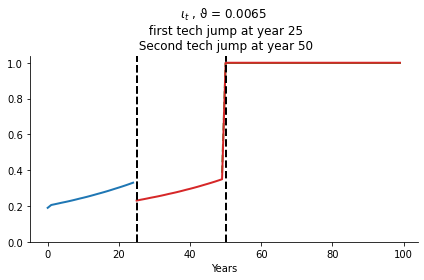

In [667]:
# iota
plt.plot(
    'years',
    'iota',
    data=df[df['years'] < t_tech_jump1],
)

plt.plot(
    'years',
    'iota',
    data=df[(df['years'] >= t_tech_jump1) & (df['years'] < t_dmg)],
)

plt.plot(
    'years',
    'iota',
    data=df[(df['years'] >= t_tech_jump2-1) & (df['years'] <= t_tech_jump2)],
    linestyle='--',
)
plt.plot('years', 'iota', data=df[df['years'] >= t_tech_jump2], color='tab:green')

plt.plot(np.arange(t_dmg, pers), iota_post[:,5])
plt.axvline(x=t_tech_jump1, linestyle='dashed', color='black')
plt.axvline(x=t_dmg, linestyle='dashed', color='black')
plt.axvline(x=t_tech_jump2, linestyle='dashed', color='black')
plt.title(
    '$ι_t$ , ϑ = 0.0065\n first tech jump at year {}\n Second tech jump at year {}'
    .format(t_tech_jump1, t_tech_jump2))
plt.xlabel('Years')
plt.ylim(0)
plt.tight_layout()
# plt.savefig('../figures/DICE_like/iotat_jump_5_test.png', dpi=300)

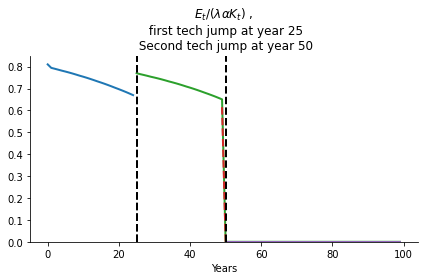

In [668]:
# ems loss
plt.plot(
    'years',
    'ems loss',
    data=df[df['years'] < t_tech_jump1],
)

plt.plot(
    'years',
    'ems loss',
    data=df[(df['years'] >= t_tech_jump1) & (df['years'] < t_dmg)],
)

plt.plot(np.arange(t_dmg, pers), 1 - iota_post[:, 5])

plt.plot(
    'years',
    'ems loss',
    data=df[(df['years'] >= t_tech_jump2 - 1) & (df['years'] <= t_tech_jump2)],
    linestyle='--',
)
plt.plot('years',
         'ems loss',
         data=df[df['years'] >= t_tech_jump2],
#          color='tab:green'
        )

plt.axvline(x=t_tech_jump1, linestyle='dashed', color='black')
plt.axvline(x=t_dmg, linestyle='dashed', color='black')
plt.axvline(x=t_tech_jump2, linestyle='dashed', color='black')
plt.title(
    '$E_t / (\\lambda \\alpha K_t) $ ,\n first tech jump at year {}\n Second tech jump at year {}'
    .format(t_tech_jump1, t_tech_jump2))
plt.xlabel('Years')
plt.ylim(0)
plt.tight_layout()
# plt.savefig('../figures/DICE_like/iota_5_test_026.png', dpi=300)

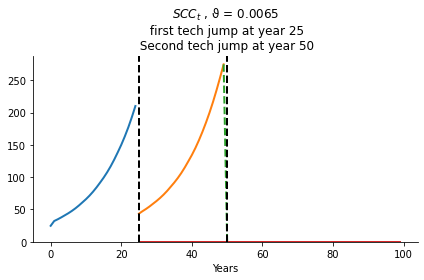

In [669]:
# SCCt
plt.plot(
    'years',
    'SCC',
    data=df[df['years'] < t_tech_jump1],
)

plt.plot(
    'years',
    'SCC',
    data=df[(df['years'] >= t_tech_jump1) & (df['years'] < t_tech_jump2)],
)

plt.plot(
    'years',
    'SCC',
    data=df[(df['years'] >= t_tech_jump2-1) & (df['years'] <= t_tech_jump2)],
    linestyle='--',
)
plt.plot('years', 'SCC', data=df[df['years'] >= t_tech_jump2], color='tab:green')

plt.plot(np.arange(t_dmg, pers), MUe_post[:,5]*1000)
plt.axvline(x=t_tech_jump1, linestyle='dashed', color='black')
# plt.axvline(x=t_dmg, linestyle='dashed', color='black')
plt.axvline(x=t_tech_jump2, linestyle='dashed', color='black')
plt.title(
    '$SCC_t$ , ϑ = 0.0065\n first tech jump at year {}\n Second tech jump at year {}'
    .format(t_tech_jump1, t_tech_jump2))
plt.xlabel('Years')
plt.ylim(0)
plt.tight_layout()
# plt.savefig('../figures/DICE_like/SCCt_jump_5_test.png', dpi=300)

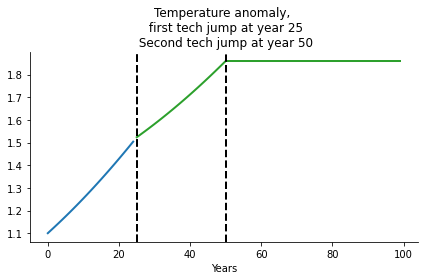

In [670]:
# temperature anomaly
# multiple line plot
plt.plot(
    'years',
    'temp ano',
    data=df[df['years'] < t_tech_jump1],
)
plt.plot(
    'years',
    'temp ano',
    data=df[(df['years'] >= t_tech_jump1) & (df['years'] < t_dmg)],
)

plt.plot(np.arange(t_dmg, pers), hist_postdmg[:, 0, 5])

# plt.plot(
#     'years',
#     'temp ano',
#     data=df[(df['years'] >= t_tech_jump2 - 1) & (df['years'] <= t_tech_jump2)],
#     linestyle='--',
# )
# plt.plot('years',
#          'temp ano',
#          data=df[df['years'] >= t_tech_jump2],
# #          color='tab:green'
#         )

plt.axvline(x=t_tech_jump1, linestyle='dashed', color='black')
plt.axvline(x=t_dmg, linestyle='dashed', color='black')
plt.axvline(x=t_tech_jump2, linestyle='dashed', color='black')
plt.title(
    'Temperature anomaly, \n first tech jump at year {}\n Second tech jump at year {}'
    .format(t_tech_jump1, t_tech_jump2))
plt.xlabel('Years')
# plt.ylim(0, 2.5)
plt.tight_layout()
# plt.savefig('../figures/DICE_like/Yt_jump_5_test_026.png', dpi=300)

In [671]:
hist[:,0]

array([1.1       , 1.11455591, 1.12911182, 1.14388293, 1.1588676 ,
       1.17406741, 1.18949162, 1.20513715, 1.22100149, 1.23708144,
       1.25337605, 1.26989513, 1.28663508, 1.30359071, 1.32075868,
       1.33813736, 1.35573356, 1.3735433 , 1.39156133, 1.40978093,
       1.42819945, 1.44682287, 1.46564418, 1.48465826, 1.50385558,
       1.5232308 , 1.53437603, 1.54566821, 1.5571215 , 1.56873419,
       1.58050346, 1.59243747, 1.60453405, 1.61679096, 1.6292046 ,
       1.64177054, 1.65449722, 1.66738183, 1.68041977, 1.69360473,
       1.70693353, 1.7204136 , 1.73403793, 1.74779938, 1.761694  ,
       1.77571782, 1.7898688 , 1.80414102, 1.81852969, 1.83303342,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765654,
       1.84765654, 1.84765654, 1.84765654, 1.84765654, 1.84765

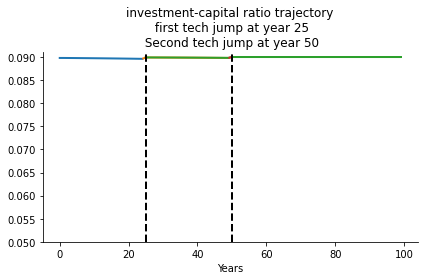

In [672]:
# investment-capital ratio
plt.plot(
    'years',
    'investment',
    data=df[df['years'] < t_tech_jump1],
)
plt.plot(
    'years',
    'investment',
    data=df[(df['years'] >= t_tech_jump1-1) & (df['years'] <= t_tech_jump1)],
    linestyle='--',
)
plt.plot(
    'years',
    'investment',
    data=df[(df['years'] >= t_tech_jump1) & (df['years'] < t_tech_jump2)],
    color='tab:orange'
)

plt.plot(np.arange(t_dmg, pers), inv_postdmg[:,5])
plt.plot(
    'years',
    'investment',
    data=df[(df['years'] >= t_tech_jump2-1) & (df['years'] <= t_tech_jump2)],
    linestyle='--',
)
plt.plot('years', 'investment', data=df[df['years'] >= t_tech_jump2], color='tab:green')
plt.axvline(x=t_tech_jump1, linestyle='dashed', color='black')
# plt.axvline(x=t_dmg, linestyle='dashed', color='black')
plt.axvline(x=t_tech_jump2, linestyle='dashed', color='black')

plt.title(
    'investment-capital ratio trajectory\n first tech jump at year {}\n Second tech jump at year {}'
    .format(t_tech_jump1, t_tech_jump2))
plt.xlabel('Years')
plt.ylim(0.05, 0.091)
plt.tight_layout()
# plt.savefig('../figures/DICE_like/It_jump_5.png', dpi=300)

In [733]:
# initial points
K_0 = 80 / α
Y_0 = 1.1
logD_0 = γ1 * Y_0 + 0.5 * γ2 * Y_0**2


nDims = 3
tech_state = 0
hist = np.zeros([pers + 1, nDims])
e_hist = np.zeros([pers + 1])
i_hist = np.zeros([pers + 1])
prob_no_tech_no_dmg = np.zeros([pers + 1])

# initial points
hist[0, :] = [Y_0, np.log(K_0), logD_0]
e_hist[0] = e_func(hist[0, :], ems0)
i_hist[0] = i_func(hist[0, :], inv0)
prob_no_tech_no_dmg[0] = 1

ems_grid = ems0
inv_grid = inv0
# no jump and prob
for tm in range(1, pers + 1):
    # damage jump happens with 1 prob to one of damage function
    if hist[tm-1, 0] <= y_grid_cap[-1]:
        e_hist[tm] = e_func(hist[tm - 1, :], ems_grid)
        i_hist[tm] = i_func(hist[tm - 1, :], inv_grid)
        hist[tm, 0] = hist[tm - 1, 0] + compute_μy(e_hist[tm - 1]) * dt  # Y
        hist[tm, 1] = hist[tm - 1, 1] + compute_μlogk(hist[tm - 1, :],
                                                      inv_grid) * dt  # logK
        hist[tm, 2] = hist[tm - 1, 2] + compute_μlogd(
            hist[tm - 1, :], e_hist[tm - 1]) * dt  # logDt
        y_t = hist[tm, 0]
        if y_t <= y_bar:
            I_y = r1 * (np.exp(r2 / 2 * (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
            dmg_jump = I_y * dt
        elif y_t > y_bar:
            dmg_jump = 1
        jump_prob = dmg_jump * (I_g_0 * dt)
        prob_no_tech_no_dmg[tm] = (1 - jump_prob) * prob_no_tech_no_dmg[tm -1]
    else:
        t_dmg_jump = tm
        print(tm)
        break

65


In [736]:
prob_no_tech_no_dmg[:t_dmg_jump+1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999247,
       0.99991914, 0.99971135, 0.99929871, 0.99860872, 0.99756332,
       0.99608011, 0.99406732, 0.9914245 , 0.98804025, 0.98379054,
       0.97853845, 0.97213181, 0.96440345, 0.95517073, 0.94423629,
       0.93138791, 0.91640159, 0.8990407 , 0.86307907, 0.82855591,
       0.79541367, 0.76359713, 0.73305324, 0.70373111, 0.67558187,
       0.        ])

Text(0.5, 0, 'Years')

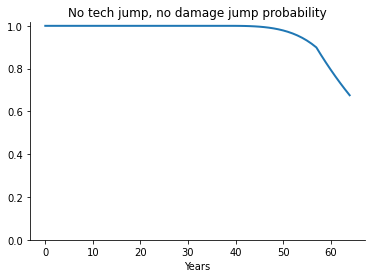

In [738]:
plt.plot(prob_no_tech_no_dmg[:t_dmg_jump])
plt.ylim(0)
plt.title('No tech jump, no damage jump probability')
plt.xlabel('Years')

In [729]:
hist[:,0]

array([1.1       , 1.11455591, 1.12911182, 1.14388293, 1.1588676 ,
       1.17406741, 1.18949162, 1.20513715, 1.22100149, 1.23708144,
       1.25337605, 1.26989513, 1.28663508, 1.30359071, 1.32075868,
       1.33813736, 1.35573356, 1.3735433 , 1.39156133, 1.40978093,
       1.42819945, 1.44682287, 1.46564418, 1.48465826, 1.50385558,
       1.5232308 , 1.54278984, 1.56252175, 1.5824203 , 1.6024747 ,
       1.62267607, 1.64302907, 1.66351942, 1.68413974, 1.70487659,
       1.72571922, 1.74666833, 1.76770832, 1.78883079, 1.81001788,
       1.83125926, 1.85259309, 1.87405788, 1.89567547, 1.91763348,
       1.93993872, 1.96278544, 1.98623892, 2.010395  , 2.03534305,
       2.06113429, 2.08784192, 2.11550105, 2.14413878, 2.17375941,
       2.20437393, 2.23595994, 2.26853145, 2.30203272, 2.33643805,
       2.37172396, 2.40783324, 2.44473419, 2.48237762, 2.52068053,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [581]:
from itertools import combinations

In [676]:
n_case_tech_only = len(list(combinations([tm for tm in range(1, pers + 1)], 2)))
jump_years = list(combinations([tm for tm in range(1, pers + 1)], 2))
# for an input of tech jump years
t_tech_1 = 1
t_tech_2 = 3


def jump_tech_only(t_tech_1, t_tech_2):
#     t_tech_1 = jump_years[0]
#     t_tech_2 = jump_years[1]
    hist = np.zeros([pers + 1, nDims])
    e = np.zeros([pers + 1])
    i = np.zeros([pers + 1])
    prob = np.zeros([pers + 1])

    # initial points
    hist[0, :] = [Y_0, np.log(K_0), logD_0]
    e[0] = e_func(hist[0, :], ems0)
    i[0] = i_func(hist[0, :], inv0)
    prob[0] = 1

    ems_grid = ems0
    inv_grid = inv0
    t_dmg = t_tech_1
    λ_bar = λ_0
    ϑ_bar = ϑ_0
    I_g = I_g_0
    for tm in range(1, pers + 1):
        # damage jump happens with 1 prob to one of damage function
        if hist[tm - 1, 0] <= y_grid_cap[-1]:
            if tm == t_tech_1:
                ems_grid = ems1
                inv_grid = inv1
                λ_bar = λ_1
                ϑ_bar = ϑ_1
                I_g = I_g_1
            elif tm == t_tech_2:
                ems_grid = ems2
                inv_grid = inv2
                λ_bar = λ_1
                ϑ_bar = ϑ_2

            e[tm] = e_func(hist[tm - 1, :], ems_grid)
            i[tm] = i_func(hist[tm - 1, :], inv_grid)
            hist[tm, 0] = hist[tm - 1, 0] + compute_μy(e[tm - 1]) * dt  # Y
            hist[tm, 1] = hist[tm - 1, 1] + compute_μlogk(hist[tm - 1, :],
                                                          inv_grid) * dt  # logK
            hist[tm, 2] = hist[tm - 1, 2] + compute_μlogd(
                hist[tm - 1, :], e[tm - 1]) * dt  # logDt
            y_t = hist[tm, 0]
            if y_t <= y_bar:
                I_y = r1 * (np.exp(r2 / 2 *
                           (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                no_dmg_prob = 1 -  I_y*dt
            elif y > y_bar:
                no_dmg_prob = 0
            if tm < t_tech_1:
                # before first jump
                prob[tm] = prob[tm-1]*(1 - I_g*dt)*no_dmg_prob
            if tm == t_tech_1 or tm == t_tech_2:
                # first jump and second jump
                prob[tm] = prob[tm-1]*I_g*dt*no_dmg_prob
            if tm > t_tech_1 and tm < t_tech_2:
                # post first jump and pre second jump
                 prob[tm] = prob[tm-1]*(1 - I_g*dt)*no_dmg_prob
            elif tm > t_tech_2:
                # both tech jumps happened
                prob[tm] = prob[tm-1]*1
        else:
            break
    return e, i, prob, hist

In [677]:
simul_tech_only = solve_parallel(jump_years, jump_tech_only)

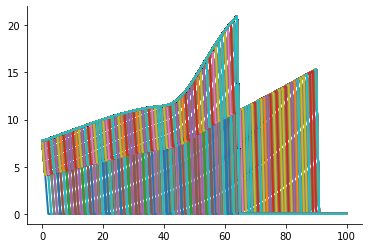

In [678]:
for i in range(n_case_tech_only):
    plt.plot(simul_tech_only[i][0])
plt.show()

In [679]:
simul_tech_only[-1][0], simul_tech_only[i][-1][:,0], simul_tech_only[i][2]

(array([ 7.81756401,  7.81756401,  7.93314105,  8.04784091,  8.16338553,
         8.2839014 ,  8.40276926,  8.52028565,  8.6360854 ,  8.75137189,
         8.87192419,  8.99055078,  9.10638748,  9.22042727,  9.33359267,
         9.45041559,  9.56510505,  9.67697179,  9.78522623,  9.89206226,
        10.00211123, 10.10838627, 10.21192416, 10.31033261, 10.40587933,
        10.50460255, 10.59744661, 10.68694359, 10.77064728, 10.84957774,
        10.9310172 , 11.00478314, 11.07458784, 11.13716977, 11.19398356,
        11.25117326, 11.29997918, 11.34427304, 11.37898463, 11.4081415 ,
        11.45779076, 11.52812496, 11.61019337, 11.79302441, 11.97950633,
        12.27032485, 12.59619228, 12.97354587, 13.39888333, 13.85173946,
        14.34390914, 14.85492956, 15.38050869, 15.90839931, 16.44218387,
        16.96394743, 17.49322866, 17.9925775 , 18.47812554, 18.95105441,
        19.39326628, 19.81844895, 20.21721511, 20.57140188, 20.93648807,
         0.        ,  0.        ,  0.        ,  0. 

In [680]:
# no tech jump and damage jump only
## damage jumps each year (0 probability before Y reaches 1.8)
# t_dmg = 64

def jump_damage_only(t_dmg):
    hist = np.zeros([pers + 1, nDims])
    e = np.zeros([pers + 1])
    i = np.zeros([pers + 1])
    prob = np.zeros([pers + 1])

    # initial points
    hist[0, :] = [Y_0, np.log(K_0), logD_0]
    e[0] = e_func(hist[0, :], ems0)
    i[0] = i_func(hist[0, :], inv0)
    prob[0] = 1

    ems_grid = ems0
    inv_grid = inv0
    λ_bar = λ_0
    ϑ_bar = ϑ_0
    prob_no_tech = 1 - I_g_0 * dt
    for tm in range(1, t_dmg):
        if hist[tm - 1, 0] <= y_grid_cap[-1]:
            e[tm] = e_func(hist[tm - 1, :], ems_grid)
            i[tm] = i_func(hist[tm - 1, :], inv_grid)
            hist[tm, 0] = hist[tm - 1, 0] + compute_μy(e[tm - 1]) * dt  # Y
            hist[tm, 1] = hist[tm - 1, 1] + compute_μlogk(hist[tm - 1, :],
                                                          inv_grid) * dt  # logK
            hist[tm, 2] = hist[tm - 1, 2] + compute_μlogd(hist[tm - 1, :],
                                                          e[tm - 1]) * dt  # logDt
            y_t = hist[tm, 0]
            if y_t <= y_bar:
                I_y = r1 * (np.exp(r2 / 2 *
                                   (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                no_dmg_prob =  1 - I_y * dt
            elif y_t > y_bar:
                no_dmg_prob = 0
            prob[tm] = prob[tm - 1] * prob_no_tech * no_dmg_prob
        else:
            break

    e_postdmg = np.zeros((pers + 1, len(γ3_list)))
    i_postdmg = np.zeros((pers + 1, len(γ3_list)))
    prob_postdmg = np.zeros((pers + 1, len(γ3_list)))
    hist_postdmg = np.zeros((pers + 1, nDims, len(γ3_list)))

    for tm in range(t_dmg):
        e_postdmg[tm, :] = e[tm]
        i_postdmg[tm, :] = i[tm]
        prob_postdmg[tm, :] = prob[tm]
        for j in range(len(γ3_list)):
            hist_postdmg[tm, :, j] = hist[tm]

    for tm in range(t_dmg, pers + 1):
        # simulate
        for j in range(len(γ3_list)):
            ems_grid = res_tech0[j]['ems']
            inv_grid = res_tech0[j]['inv']
            if tm == t_dmg:
                e_postdmg[tm, j] = e_func(hist[t_dmg - 1, :], ems_grid, False)
                i_postdmg[tm, j] = i_func(hist[t_dmg - 1, :], inv_grid, False)
                hist_postdmg[tm, 0,
                             j] = hist[t_dmg - 1,
                                       0] + compute_μy(e_hist[t_dmg - 1]) * dt
                hist_postdmg[tm, 1, j] = hist[t_dmg - 1, 1] + compute_μlogk(
                    hist[t_dmg - 1, :], inv_grid, False) * dt
                hist_postdmg[tm, 2, :] = hist[t_dmg - 1, 2] + compute_μlogd(
                    hist[t_dmg - 1, :], e_hist[t_dmg - 1]) * dt
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)

                prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * prob_no_tech * dmg_prob
            elif tm > t_dmg:
                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * prob_no_tech * 1
    return e_postdmg, i_postdmg, prob_postdmg, hist_postdmg

In [682]:
jump_years_damage_only = [(t,) for t in range(1, 65 + 1)]
simul_damage_only = solve_parallel(jump_years_damage_only, jump_damage_only)

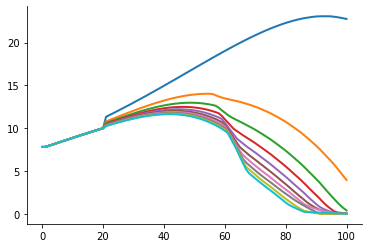

In [683]:
plt.plot(simul_damage_only[20][0])
plt.show()

In [684]:
# tech jump and damage jump both happens
## use tech jump no damage jump as input (no jump trajectory)
t_tech_1 = 30
t_tech_2 = 63
t_jump = 63

# initial points
def two_tech_damage(tech_years, t_jump):
    t_tech_1 = tech_years[0]
    t_tech_2 = tech_years[1]
    K_0 = 80 / α
    Y_0 = 1.1
    logD_0 = γ1 * Y_0 + 0.5 * γ2 * Y_0**2

    T = 100
    dt = 1
    pers = int(T / dt)

    nDims = 3
    tech_state = 0
    hist = np.zeros([pers + 1, nDims])
    e_hist = np.zeros([pers + 1])
    i_hist = np.zeros([pers + 1])
    prob_tech_dmg = np.zeros([pers + 1, len(γ3_list)])

    # initial points
    ems_grid = ems0
    inv_grid = inv0
    I_g = I_g_0
    e_postdmg = np.zeros((pers + 1, len(γ3_list)))
    i_postdmg = np.zeros((pers + 1, len(γ3_list)))
    prob_postdmg = np.zeros((pers + 1, len(γ3_list)))
    hist_postdmg = np.zeros((pers + 1, nDims, len(γ3_list)))

    for j in range(len(γ3_list)):
        hist_postdmg[0, :, j] = [Y_0, np.log(K_0), logD_0]
    e_postdmg[0] = e_func(hist_postdmg[0, :, 0], ems0)
    i_postdmg[0] = i_func(hist_postdmg[0, :, 0], inv0)
    prob_postdmg[0] = 1

    if t_jump < t_tech_1:
        for tm in range(1, t_jump):
            if hist_postdmg[tm - 1, 0, 0] <= y_grid_cap[-1]:
                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1]) * dt  # Y
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                prob_no_tech = 1 - I_g * dt
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y_t > y_bar:
                    no_dmg_prob = 0
                prob_postdmg[tm] = prob_postdmg[tm -
                                                1] * prob_no_tech * no_dmg_prob
            else:
                break
        res_tech = res_tech0
        for tm in range(t_jump, pers + 1):
            if tm == t_tech_1:
                res_tech = res_tech1
                I_g = I_g_1
            elif tm == t_tech_2:
                res_tech = res_tech2

            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_jump:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1,
                                                   j] * (1 - I_g * dt) * dmg_prob
                elif tm > t_jump and tm < t_tech_1:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1
                elif tm == t_tech_1:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * I_g * dt * 1
                elif tm > t_tech_1 and tm < t_tech_2:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1
                elif tm == t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * I_g * dt * 1
                elif tm > t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * 1

    elif t_jump == t_tech_1:
        for tm in range(1, t_tech_1):
            if hist_postdmg[tm - 1, 0, 0] <= y_grid_cap[-1]:

                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1]) * dt  # Y
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                prob_no_tech = 1 - I_g * dt
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y_t > y_bar:
                    no_dmg_prob = 0

                prob_postdmg[tm] = prob_postdmg[tm - 1] * (1 -
                                                           I_g * dt) * no_dmg_prob
            else:
                break

        res_tech = res_tech1
        I_g = I_g_1
        for tm in range(t_tech_1, pers + 1):
            if tm == t_tech_2:
                res_tech = res_tech2

            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_tech_1:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1,
                                                   j] * I_g * dt * dmg_prob
                elif tm > t_tech_1 and tm < t_tech_2:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1
                elif tm == t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * I_g * dt * 1
                elif tm > t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * 1

    elif t_jump > t_tech_1 and t_jump < t_tech_2:
        for tm in range(1, t_jump):
            if hist_postdmg[tm - 1, 0, 0] <= y_grid_cap[-1]:
                if tm == t_tech_1:
                    ems_grid = ems1
                    inv_grid = inv1
                    λ_bar = λ_1
                    ϑ_bar = ϑ_1
                    I_g = I_g_1

                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1]) * dt  # Y
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                prob_no_tech = 1 - I_g * dt
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y_t > y_bar:
                    no_dmg_prob = 0
                if tm != t_tech_1:
                    prob_postdmg[tm] = prob_postdmg[tm - 1] * (
                        1 - I_g * dt) * no_dmg_prob
                elif tm == t_tech_1:
                    prob_postdmg[tm] = prob_postdmg[tm -
                                                    1] * I_g * dt * no_dmg_prob
            else:
                break

        res_tech = res_tech1
        for tm in range(t_jump, pers + 1):
            if tm == t_tech_2:
                res_tech = res_tech2

            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_jump:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1,
                                                   j] * (1 - I_g * dt) * dmg_prob
                elif tm > t_jump and tm < t_tech_2:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1
                elif tm == t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * I_g * dt * 1
                elif tm > t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * 1

    elif t_jump == t_tech_2:
        for tm in range(1, t_tech_2):
            # damage jump happens with 1 prob to one of damage function
            if hist[tm - 1, 0] <= y_grid_cap[-1]:
                if tm == t_tech_1:
                    ems_grid = ems1
                    inv_grid = inv1
                    λ_bar = λ_1
                    ϑ_bar = ϑ_1
                    I_g = I_g_1

                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1, 0]) * dt
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y > y_bar:
                    no_dmg_prob = 0
                if tm < t_tech_1:
                    # before first jump
                    prob[tm] = prob[tm - 1] * (1 - I_g * dt) * no_dmg_prob
                if tm == t_tech_1:
                    # first jump and second jump
                    prob[tm] = prob[tm - 1] * I_g * dt * no_dmg_prob
                if tm > t_tech_1:
                    # post first jump and pre second jump
                    prob[tm] = prob[tm - 1] * (1 - I_g * dt) * no_dmg_prob

            else:
                break

        res_tech = res_tech2
        for tm in range(t_tech_2, pers + 1):
            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * I_g*dt * dmg_prob
                elif tm > t_tech_2:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * 1 * 1

    elif t_jump > t_tech_2:
        for tm in range(1, t_jump):
            # damage jump happens with 1 prob to one of damage function
            if hist[tm - 1, 0] <= y_grid_cap[-1]:
                if tm == t_tech_1:
                    ems_grid = ems1
                    inv_grid = inv1
                    λ_bar = λ_1
                    ϑ_bar = ϑ_1
                    I_g = I_g_1
                elif tm == t_tech_2:
                    ems_grid = ems2
                    inv_grid = inv2
                    λ_bar = λ_1
                    ϑ_bar = ϑ_2

                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1, 0]) * dt
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y > y_bar:
                    no_dmg_prob = 0
                if tm < t_tech_1:
                    # before first jump
                    prob[tm] = prob[tm - 1] * (1 - I_g * dt) * no_dmg_prob
                if tm == t_tech_1 or tm == t_tech_2:
                    # first jump and second jump
                    prob[tm] = prob[tm - 1] * I_g * dt * no_dmg_prob
                if tm > t_tech_1 and tm < t_tech_2:
                    # post first jump and pre second jump
                    prob[tm] = prob[tm - 1] * (1 - I_g * dt) * no_dmg_prob
                elif tm > t_tech_2:
                    # both tech jumps happened
                    prob[tm] = prob[tm - 1] * 1
            else:
                break

        res_tech = res_tech2
        for tm in range(t_jump, pers + 1):
            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_jump:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * 1 * dmg_prob
                elif tm > t_jump:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * 1 * 1

    return e_postdmg, i_postdmg, prob_postdmg, hist_postdmg

In [532]:
args_list = []
for t in range(1, pers + 1):
    for tech_years in jump_years:
        args_list.append((tech_years, t) )
simul_two_tech_damage = solve_parallel(args_list, two_tech_damage)

Process ForkPoolWorker-314:
Process ForkPoolWorker-321:
Process ForkPoolWorker-318:
Process ForkPoolWorker-324:
Process ForkPoolWorker-323:
Process ForkPoolWorker-322:
Process ForkPoolWorker-313:
Process ForkPoolWorker-317:
Process ForkPoolWorker-315:


KeyboardInterrupt: 

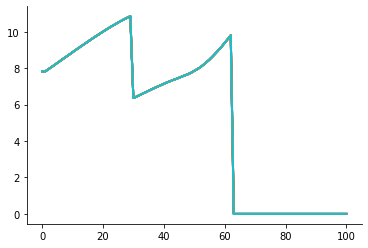

In [685]:
plt.plot(e_postdmg)
plt.show()

In [686]:
def one_tech_damage(t_tech_1, t_jump):
    K_0 = 80 / α
    Y_0 = 1.1
    logD_0 = γ1 * Y_0 + 0.5 * γ2 * Y_0**2

    nDims = 3
    # initial points
    ems_grid = ems0
    inv_grid = inv0
    I_g = I_g_0
    e_postdmg = np.zeros((pers + 1, len(γ3_list)))
    i_postdmg = np.zeros((pers + 1, len(γ3_list)))
    prob_postdmg = np.zeros((pers + 1, len(γ3_list)))
    hist_postdmg = np.zeros((pers + 1, nDims, len(γ3_list)))

    for j in range(len(γ3_list)):
        hist_postdmg[0, :, j] = [Y_0, np.log(K_0), logD_0]
    e_postdmg[0] = e_func(hist_postdmg[0, :, 0], ems0)
    i_postdmg[0] = i_func(hist_postdmg[0, :, 0], inv0)
    prob_postdmg[0] = 1

    if t_jump < t_tech_1:
        for tm in range(1, t_jump):
            if hist_postdmg[tm - 1, 0, 0] <= y_grid_cap[-1]:
                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1]) * dt  # Y
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                prob_no_tech = 1 - I_g * dt
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y_t > y_bar:
                    no_dmg_prob = 0
                prob_postdmg[tm] = prob_postdmg[tm -
                                                1] * prob_no_tech * no_dmg_prob
            else:
                break
        res_tech = res_tech0
        for tm in range(t_jump, pers + 1):
            if tm == t_tech_1:
                res_tech = res_tech1
                I_g = I_g_1
            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_jump:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1,
                                                   j] * (1 - I_g * dt) * dmg_prob
                elif tm > t_jump and tm < t_tech_1:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1
                elif tm == t_tech_1:
                    prob_postdmg[tm, j] = prob_postdmg[tm - 1, j] * I_g * dt * 1
                elif tm > t_tech_1:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1

    elif t_jump == t_tech_1:
        for tm in range(1, t_tech_1):
            if hist_postdmg[tm - 1, 0, 0] <= y_grid_cap[-1]:

                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1]) * dt  # Y
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                prob_no_tech = 1 - I_g * dt
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y_t > y_bar:
                    no_dmg_prob = 0

                prob_postdmg[tm] = prob_postdmg[tm - 1] * (1 -
                                                           I_g * dt) * no_dmg_prob
            else:
                break

        res_tech = res_tech1
        I_g = I_g_1
        for tm in range(t_tech_1, pers + 1):
            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_tech_1:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1,
                                                   j] * I_g * dt * dmg_prob
                elif tm > t_tech_1:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1

    elif t_jump > t_tech_1:
        for tm in range(1, t_jump):
            if hist_postdmg[tm - 1, 0, 0] <= y_grid_cap[-1]:
                if tm == t_tech_1:
                    ems_grid = ems1
                    inv_grid = inv1
                    λ_bar = λ_1
                    ϑ_bar = ϑ_1
                    I_g = I_g_1

                e_postdmg[tm] = e_func(hist_postdmg[tm - 1, :, 0], ems_grid)
                i_postdmg[tm] = i_func(hist_postdmg[tm - 1, :, 0], inv_grid)
                hist_postdmg[tm, 0] = hist_postdmg[tm - 1, 0, 0] + compute_μy(
                    e_postdmg[tm - 1]) * dt  # Y
                hist_postdmg[tm, 1] = hist_postdmg[tm - 1, 1, 0] + compute_μlogk(
                    hist_postdmg[tm - 1, :, 0], inv_grid) * dt  # logK
                hist_postdmg[tm, 2] = hist_postdmg[tm - 1, 2, 0] + compute_μlogd(
                    hist_postdmg[tm - 1, :, 0], e_postdmg[tm - 1, 0]) * dt  # logDt
                y_t = hist_postdmg[tm, 0, 0]
                prob_no_tech = 1 - I_g * dt
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    no_dmg_prob = 1 - I_y * dt
                elif y_t > y_bar:
                    no_dmg_prob = 0
                if tm != t_tech_1:
                    prob_postdmg[tm] = prob_postdmg[tm - 1] * (
                        1 - I_g * dt) * no_dmg_prob
                elif tm == t_tech_1:
                    prob_postdmg[tm] = prob_postdmg[tm -
                                                    1] * I_g * dt * no_dmg_prob
            else:
                break

        res_tech = res_tech1
        for tm in range(t_jump, pers + 1):
            # simulate
            for j in range(len(γ3_list)):
                ems_grid = res_tech[j]['ems']
                inv_grid = res_tech[j]['inv']

                e_postdmg[tm, j] = e_func(hist_postdmg[tm - 1, :, j], ems_grid,
                                          False)
                i_postdmg[tm, j] = i_func(hist_postdmg[tm - 1, :, j], inv_grid,
                                          False)
                hist_postdmg[tm, 0, j] = hist_postdmg[tm - 1, 0, j] + compute_μy(
                    e_postdmg[tm - 1, j]) * dt
                hist_postdmg[tm, 1,
                             j] = hist_postdmg[tm - 1, 1, j] + compute_μlogk(
                                 hist_postdmg[tm - 1, :, j], inv_grid, False) * dt
                hist_postdmg[
                    tm, 2, j] = hist_postdmg[tm - 1, 2, j] + compute_μlogd(
                        hist_postdmg[tm - 1, :, j], e_postdmg[tm - 1, j]) * dt
                # no tech jump:
                y_t = hist_postdmg[tm, 0, j]
                if y_t <= y_bar:
                    I_y = r1 * (np.exp(r2 / 2 *
                                       (y_t - y_lower)**2) - 1) * (y_t >= y_lower)
                    dmg_prob = I_y * dt / len(γ3_list)
                elif y_t > y_bar:
                    dmg_prob = 1 / len(γ3_list)
                if tm == t_jump:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1,
                                                   j] * (1 - I_g * dt) * dmg_prob
                elif tm > t_jump:
                    prob_postdmg[tm,
                                 j] = prob_postdmg[tm - 1, j] * (1 - I_g * dt) * 1

    
    return e_postdmg, i_postdmg, prob_postdmg, hist_postdmg

In [688]:
simul_one_tech_damage = []
args_list = []
for t_tech in range(1, 60 + 1):
    for t_jump in range(1, 60 + 1):
        args_list.append((t_tech, t_jump))

simul_one_tech_damage = solve_parallel(args_list, one_tech_damage)    

Process ForkPoolWorker-413:
Process ForkPoolWorker-416:
Process ForkPoolWorker-414:
Process ForkPoolWorker-417:
Process ForkPoolWorker-419:
Process ForkPoolWorker-418:


KeyboardInterrupt: 

In [689]:
tech_only_e = []
tech_only_prob = []
for i in range(len(simul_tech_only)):
    tech_only_e.append(simul_tech_only[i][0][-1])
    tech_only_prob.append(simul_tech_only[i][2][-1])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.00000000e+00, 4.08604565e-10, 8.17209130e-10, 1.22581369e-09,
        1.63441826e-09, 2.04302282e-09, 2.45162739e-09, 2.86023195e-09,
        3.26883652e-09, 3.67744108e-09, 4.08604565e-09]),
 <BarContainer object of 10 artists>)

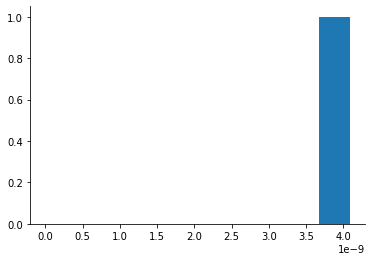

In [693]:
plt.hist(tech_only_e, weights=tech_only_prob/np.sum(tech_only_prob))

In [718]:
damage_only_e = []
damage_only_prob = []
for i in range(len(simul_damage_only)):
    damage_only_e.append(simul_damage_only[i][0][60,0:])
    damage_only_prob.append(simul_damage_only[i][2][60, 0:])

In [695]:
one_tech_damage_e = []
one_tech_damage_prob = []
for i in range(len(simul_one_tech_damage)):
    one_tech_damage_e.append(simul_one_tech_damage[i][0][-1])
    one_tech_damage_prob.append(simul_one_tech_damage[i][2][-1])

In [690]:
tech_only_e = np.array(tech_only_e)
tech_only_prob = np.array(tech_only_prob)

In [720]:
damage_only_e = np.array(damage_only_e)
damage_only_prob = np.array(damage_only_prob)

(array([0.        , 0.00857574, 0.01200391, 0.03547551, 0.06865213,
        0.20717693, 0.17980859, 0.12634579, 0.07558916, 0.08637223,
        0.        , 0.1       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.1       ]),
 array([ 5.93369535,  6.6066739 ,  7.27965244,  7.95263099,  8.62560954,
         9.29858808,  9.97156663, 10.64454517, 11.31752372, 11.99050227,
        12.66348081, 13.33645936, 14.00943791, 14.68241645, 15.355395  ,
        16.02837355, 16.70135209, 17.37433064, 18.04730919, 18.72028773,
        19.39326628]),
 <BarContainer object of 20 artists>)

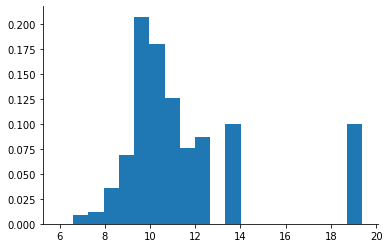

In [721]:
plt.hist(damage_only_e.flatten(),
         weights=damage_only_prob.flatten() / damage_only_prob.flatten().sum(),
         bins=20)

In [612]:
one_tech_damage_e = np.array(one_tech_damage_e)
one_tech_damage_prob = np.array(one_tech_damage_prob)

In [605]:
e_hist[-1], prob_no_tech_no_dmg[-1]

(19.393266278188, 0.9697187391936687)

In [623]:
tech_only_e.shape, damage_only_e.flatten().shape, one_tech_damage_e.flatten().shape

((1770,), (600,), (36000,))

In [651]:
# e = np.append(tech_only_e, damage_only_e.flatten())
e = np.append(damage_only_e.flatten(), one_tech_damage_e.flatten())
# prob = np.append(tech_only_prob, damage_only_prob.flatten())
prob = np.append(damage_only_prob.flatten(), one_tech_damage_prob.flatten())

In [652]:
e.shape, prob.sum()

((36600,), 0.19616387897288318)

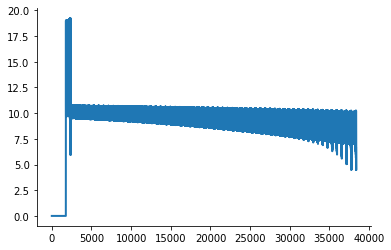

In [643]:
plt.plot(e)

(array([3.08556213e-05, 2.89764597e-04, 1.65114931e-03, 1.29338389e-02,
        2.95456801e-02, 3.73986767e-02, 3.20006477e-02, 2.90576170e-02,
        2.12132867e-02, 6.84008448e-03, 7.93181481e-03, 0.00000000e+00,
        8.63523145e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.63523145e-03]),
 array([ 4.48195973,  5.21900449,  5.95604924,  6.693094  ,  7.43013875,
         8.1671835 ,  8.90422826,  9.64127301, 10.37831777, 11.11536252,
        11.85240727, 12.58945203, 13.32649678, 14.06354154, 14.80058629,
        15.53763104, 16.2746758 , 17.01172055, 17.74876531, 18.48581006,
        19.22285481]),
 <BarContainer object of 20 artists>)

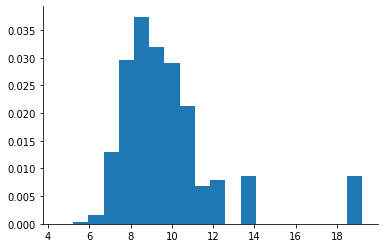

In [645]:
plt.hist(e, weights=prob, bins=20)

(0.0, 0.5)

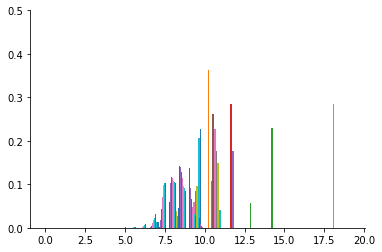

In [615]:
plt.hist(tech_only_e, weights=tech_only_prob/(1 - prob_no_tech_no_dmg[-1]))
plt.hist(damage_only_e, weights=damage_only_prob/(1-prob_no_tech_no_dmg[-1]))
plt.hist(one_tech_damage_e, weights=one_tech_damage_prob/(1-prob_no_tech_no_dmg[-1]))
plt.ylim(0,0.5)
# plt.hist(e_hist[-1], weights=prob_no_tech_no_dmg[-1])

(1770,)